In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from matplotlib import gridspec

from data_utils import (
    get_data_for_barrier_plot,
)
from meteo_utils import (
    get_wind_chill,
    get_wind_chill_mask,
    get_windspeed,
    kelvin_to_celsius,
    ms_to_kmh,
)
from plot_utils import add_headers

In [2]:
# plotting helper function
def add_label_to_axes(ax: mpl.axes.Axes, label, xpos=0.04, ypos=0.95):
    """Small helper function that adds a label to an Axes of a matplotlib plot.

    Args:
        ax (mpl.axes.Axes): A matplotlib axes.
        label (_type_): A label to add to the axes.
        xpos (float, optional): x position of the label. Defaults to 0.04.
        ypos (float, optional): y position of the label. Defaults to 0.95.

    """
    ax.text(
        xpos,
        ypos,
        label,
        ha="left",
        va="top",
        bbox={
            "facecolor": "white",
            "edgecolor": "none",
            "boxstyle": "square",
            "pad": 0.1,
        },
        transform=ax.transAxes,
    )


letters = ["A", "B", "C", "D", "E", "F", "G"]

In [3]:
# plotting config
plt.rcParams.update({"font.size": 8})
plt.rcParams["figure.dpi"] = 300
mpl.rcParams["hatch.linewidth"] = 0.5
plt.style.use("tableau-colorblind10")
alphabet_letters = np.array(
    list(map(chr, range(65, 91)))
)  # used for labelling subplots
textwidth = 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch  # textwidth in inches

In [4]:
time_slice_peak = slice(
    np.datetime64("2021-02-13T00:00"), np.datetime64("2021-02-17T23:00")
)
# -106.64719063660635,25.840437651866516,-93.5175532104321,36.50050935248352
bb_texas = {"longitude": slice(253, 267), "latitude": slice(25, 37)}

In [5]:
# load preprocessed data
gt_data = xr.open_dataset("data/2021_NA_winter_storm_gt.nc")
fc_data = xr.open_dataset("data/2021_NA_winter_storm_fc.nc")

# time series at college station
f = pd.read_csv(
    "data/2021_NA_winter_storm_college_station_ts.csv",
    sep=",",
)

/tmp/ipykernel_3517118/3230907495.py:6: DtypeWarning: Columns (38,49,88) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.read_csv(


In [6]:
# calculate wind speed:
gt_data["surface_windspeed"] = get_windspeed(
    gt_data["10m_u_component_of_wind"], gt_data["10m_v_component_of_wind"]
)

fc_data["surface_windspeed"] = get_windspeed(
    fc_data["10m_u_component_of_wind"], fc_data["10m_v_component_of_wind"]
)

# calculate wind chill:
gt_data["wind_chill"] = get_wind_chill(
    T_2m=kelvin_to_celsius(gt_data["2m_temperature"]),
    speed_10m=ms_to_kmh(
        get_windspeed(
            u=gt_data["10m_u_component_of_wind"], v=gt_data["10m_v_component_of_wind"]
        )
    ),
)

fc_data["wind_chill"] = get_wind_chill(
    T_2m=kelvin_to_celsius(fc_data["2m_temperature"]),
    speed_10m=ms_to_kmh(
        get_windspeed(
            u=fc_data["10m_u_component_of_wind"], v=fc_data["10m_v_component_of_wind"]
        )
    ),
)

# calculate wind chill mask:
gt_data["wind_chill_mask"] = get_wind_chill_mask(
    T_2m=kelvin_to_celsius(gt_data["2m_temperature"]),
    speed_10m=ms_to_kmh(
        get_windspeed(
            u=gt_data["10m_u_component_of_wind"], v=gt_data["10m_v_component_of_wind"]
        )
    ),
)

fc_data["wind_chill_mask"] = get_wind_chill_mask(
    T_2m=kelvin_to_celsius(fc_data["2m_temperature"]),
    speed_10m=ms_to_kmh(
        get_windspeed(
            u=fc_data["10m_u_component_of_wind"], v=fc_data["10m_v_component_of_wind"]
        )
    ),
)

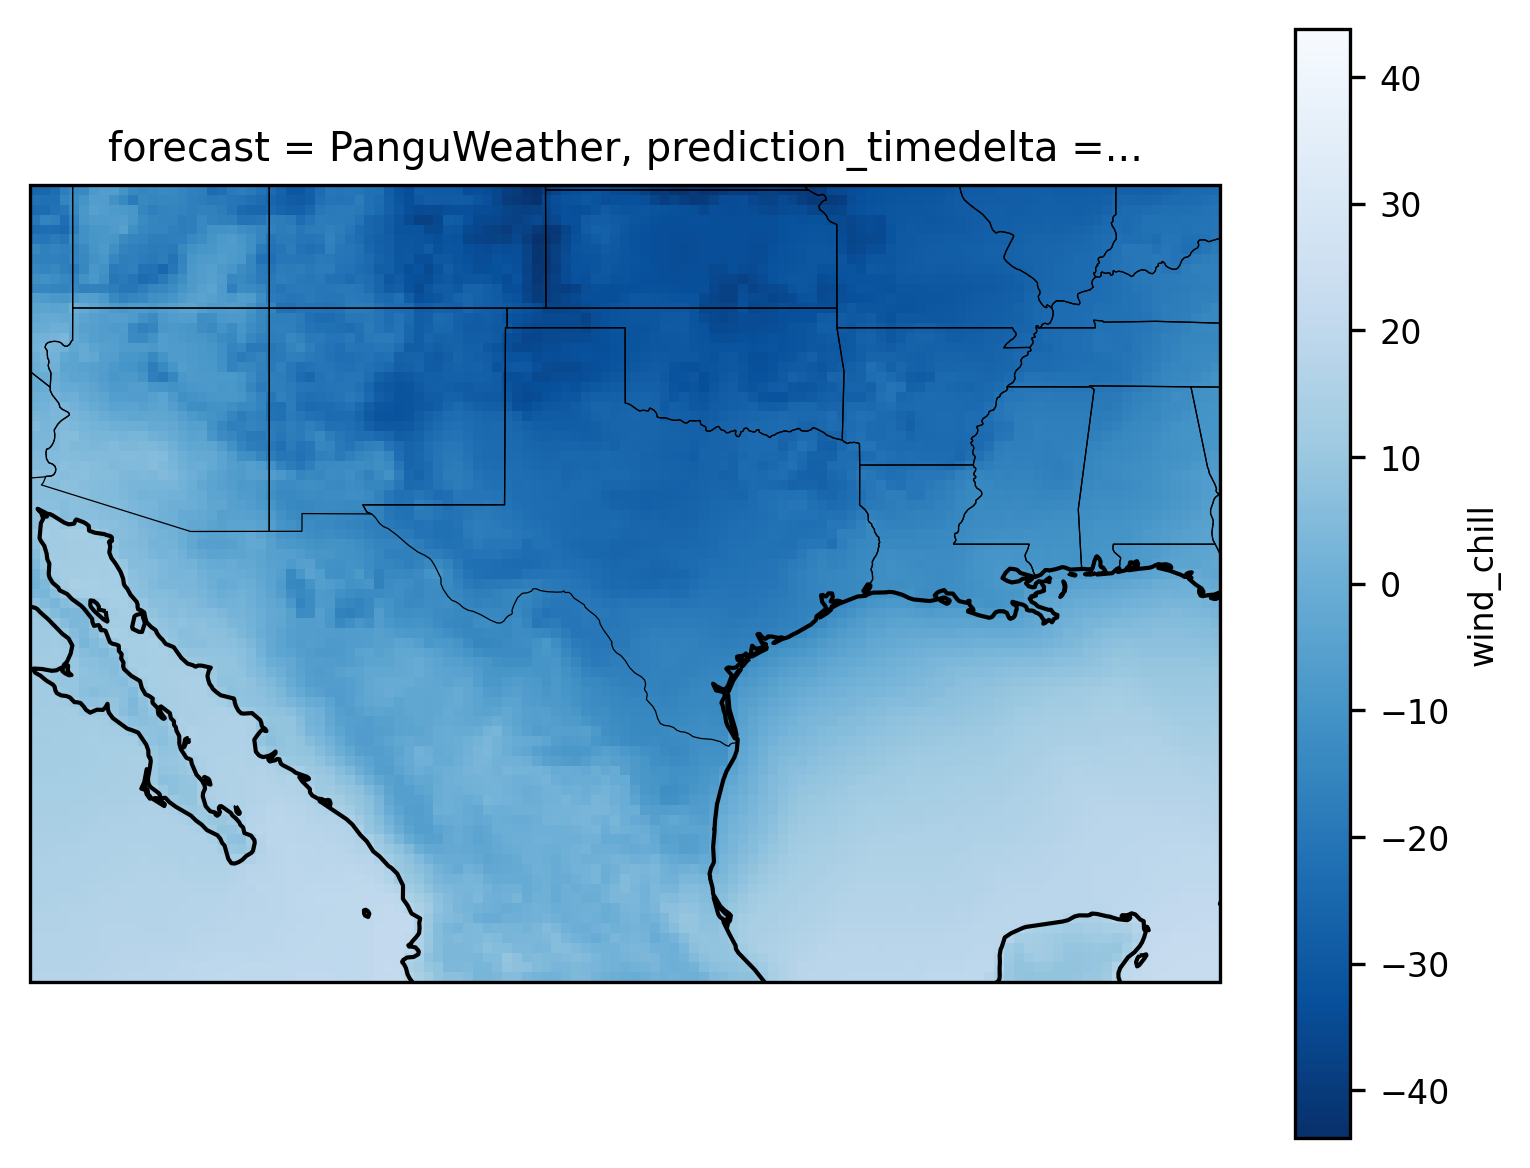

In [7]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

fc_data["wind_chill"].sel(forecast="PanguWeather").isel(
    {"prediction_timedelta": 0}
).min("time").plot(ax=ax, cmap="Blues_r")  # .sel(bb_texas)
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="k")

# Reproduce time series at College Station

In [8]:
college_station_coords = {"latitude": 30.6280, "longitude": 360 - 96.3344360}

In [9]:
f["col_split_wind"] = f["WND"].str.split(",")
f["col_split_temp"] = f["TMP"].str.split(",")
mask = (
    (f["col_split_wind"].str[2] == "N")
    & (f["col_split_wind"].str[-1] == "5")
    & (f["col_split_temp"].str[-1] == "5")
)

In [10]:
windspeeds = f["col_split_wind"][mask].apply(lambda x: float(x[-2])) / 10
temperatures = f["col_split_temp"][mask].apply(lambda x: float(x[-2])) / 10
datetimes = f["DATE"][mask].apply(lambda x: np.datetime64(x))

college_station = xr.Dataset()
college_station = college_station.assign_coords({"time": ("time", datetimes)})
college_station["temperature"] = "time", temperatures
college_station["surface_windspeed"] = "time", windspeeds

college_station["wind_chill"] = get_wind_chill(
    T_2m=college_station["temperature"],
    speed_10m=ms_to_kmh(college_station["surface_windspeed"]),
)

college_station["wind_chill_mask"] = get_wind_chill_mask(
    T_2m=college_station["temperature"],
    speed_10m=ms_to_kmh(college_station["surface_windspeed"]),
)

college_station = college_station.sel(
    time=slice(np.datetime64("2021-02-01"), np.datetime64("2021-03-01")), drop=True
)

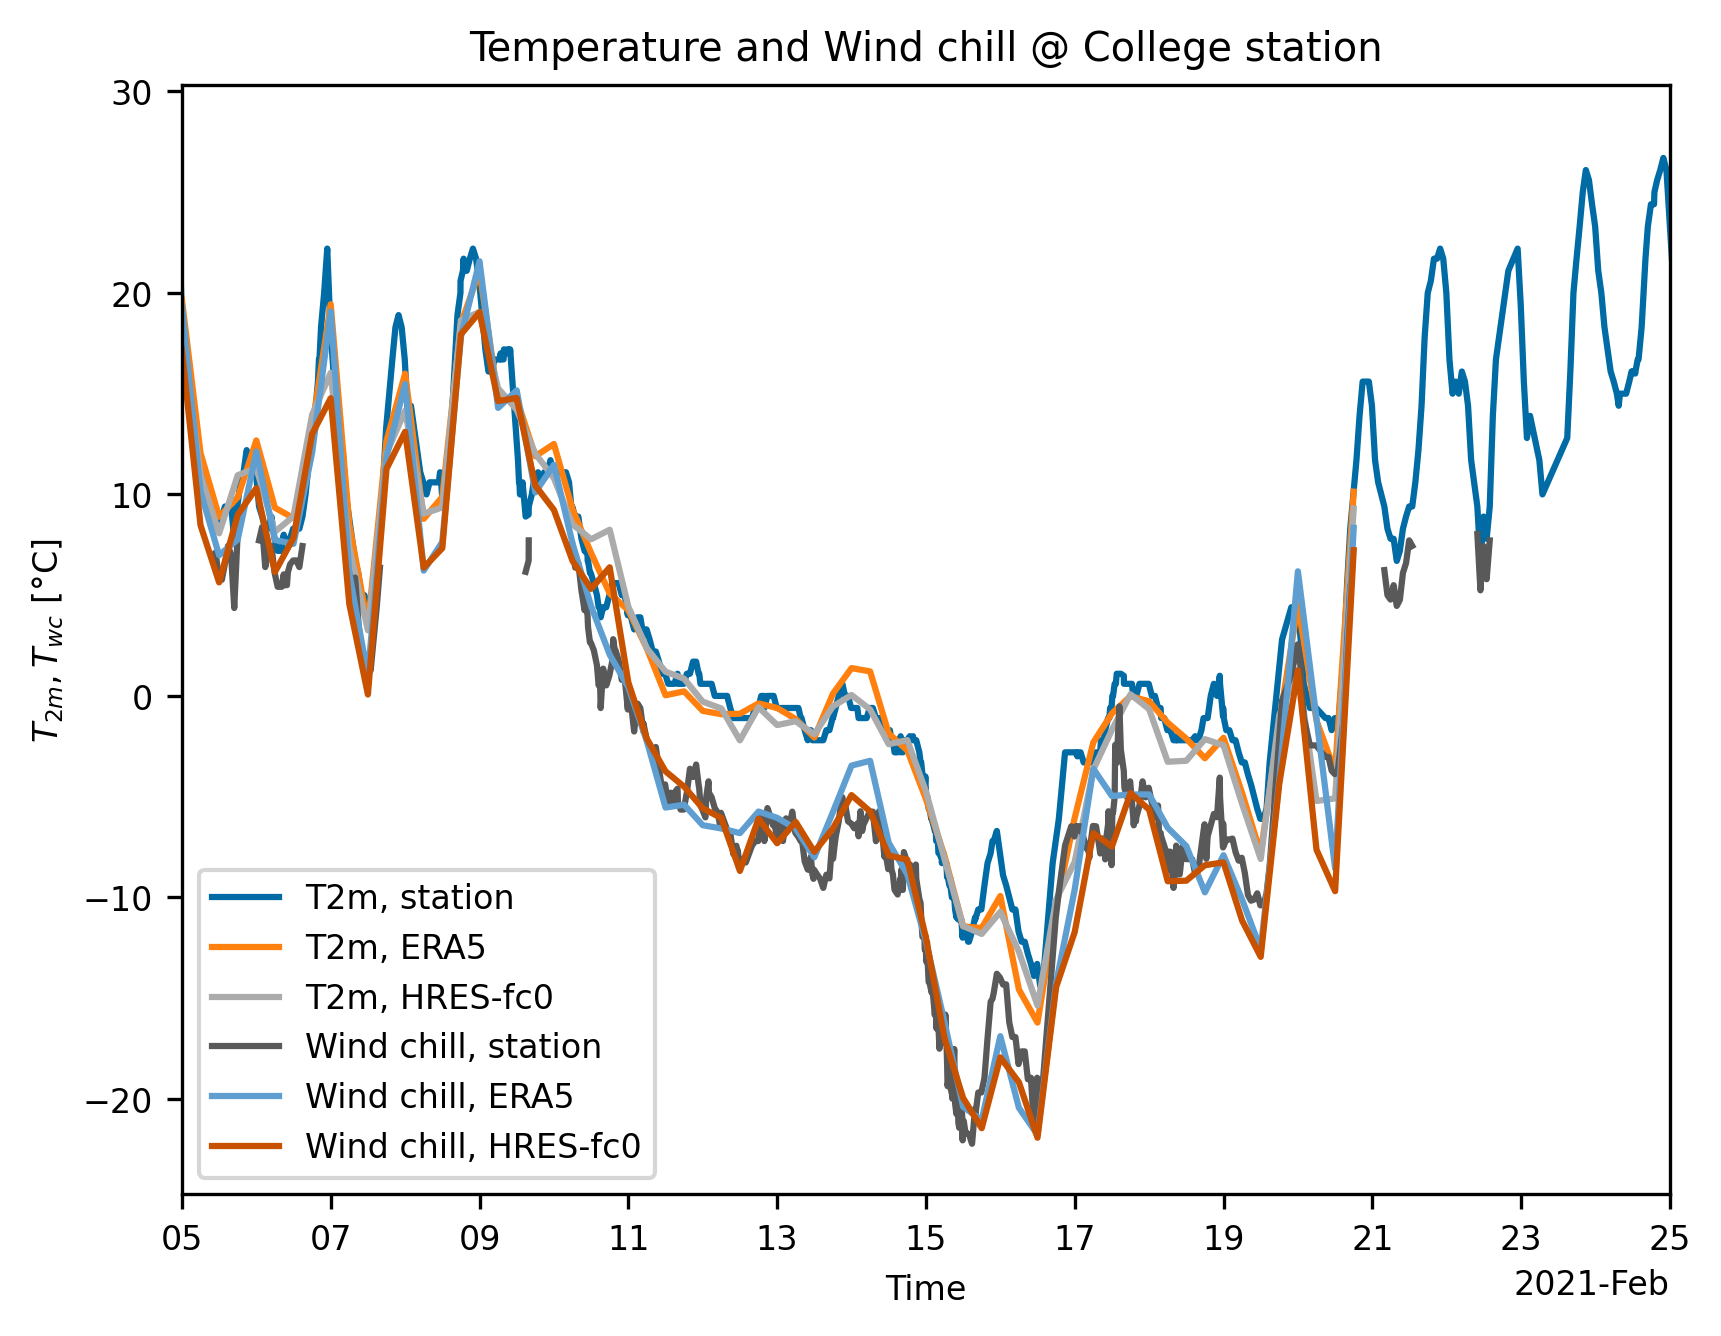

In [11]:
college_station["temperature"].plot(label="T2m, station")

kelvin_to_celsius(
    gt_data["2m_temperature"]
    .sel(source="ERA5")
    .sel(college_station_coords, method="nearest")
).plot(label="T2m, ERA5")

kelvin_to_celsius(
    gt_data["2m_temperature"]
    .sel(source="HRES_t0")
    .sel(college_station_coords, method="nearest")
).plot(label="T2m, HRES-fc0")

college_station["wind_chill"].where(college_station["wind_chill_mask"]).plot(
    label="Wind chill, station"
)

gt_data["wind_chill"].sel(college_station_coords, method="nearest").sel(
    source="ERA5"
).plot(label="Wind chill, ERA5")

gt_data["wind_chill"].sel(college_station_coords, method="nearest").sel(
    source="HRES_t0"
).plot(label="Wind chill, HRES-fc0")

plt.legend()
plt.xlabel("Time")
plt.xlim([np.datetime64("2021-02-05"), np.datetime64("2021-02-25")])

plt.ylabel("$T_{2m}, T_{wc}$ [°C]")

plt.title("Temperature and Wind chill @ College station")

plt.savefig("images/2021_NA_winterstorm_college_station_timeseries.png")

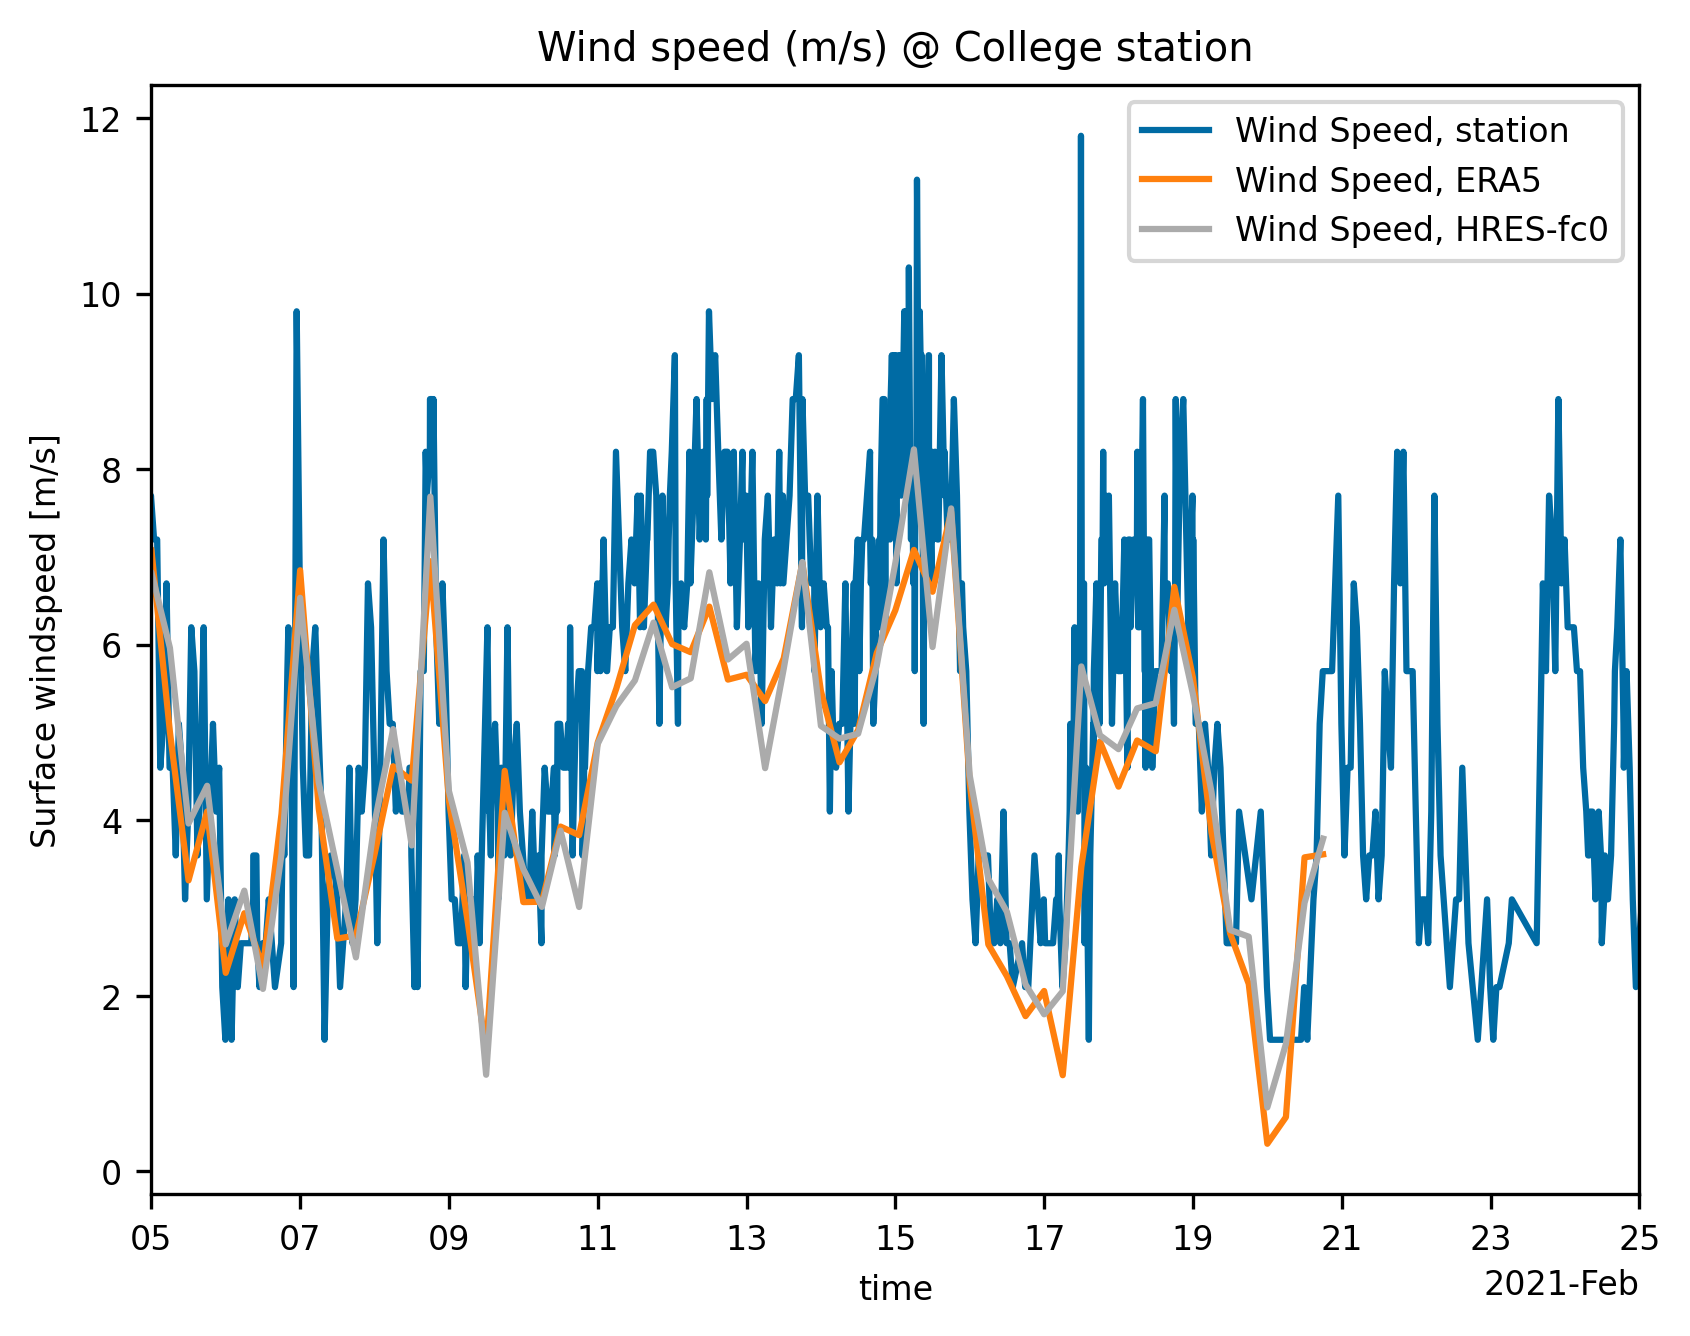

In [12]:
college_station["surface_windspeed"].plot(label="Wind Speed, station")

gt_data["surface_windspeed"].sel(college_station_coords, method="nearest").sel(
    source="ERA5"
).plot(label="Wind Speed, ERA5")

gt_data["surface_windspeed"].sel(college_station_coords, method="nearest").sel(
    source="HRES_t0"
).plot(label="Wind Speed, HRES-fc0")

plt.xlim([np.datetime64("2021-02-05"), np.datetime64("2021-02-25")])

plt.legend()
plt.ylabel("Surface windspeed [m/s]")
plt.title("Wind speed (m/s) @ College station")

plt.savefig("images/2021_NA_winterstorm_college_station_windspeed_timeseries.png")

# Predictability barrier plots

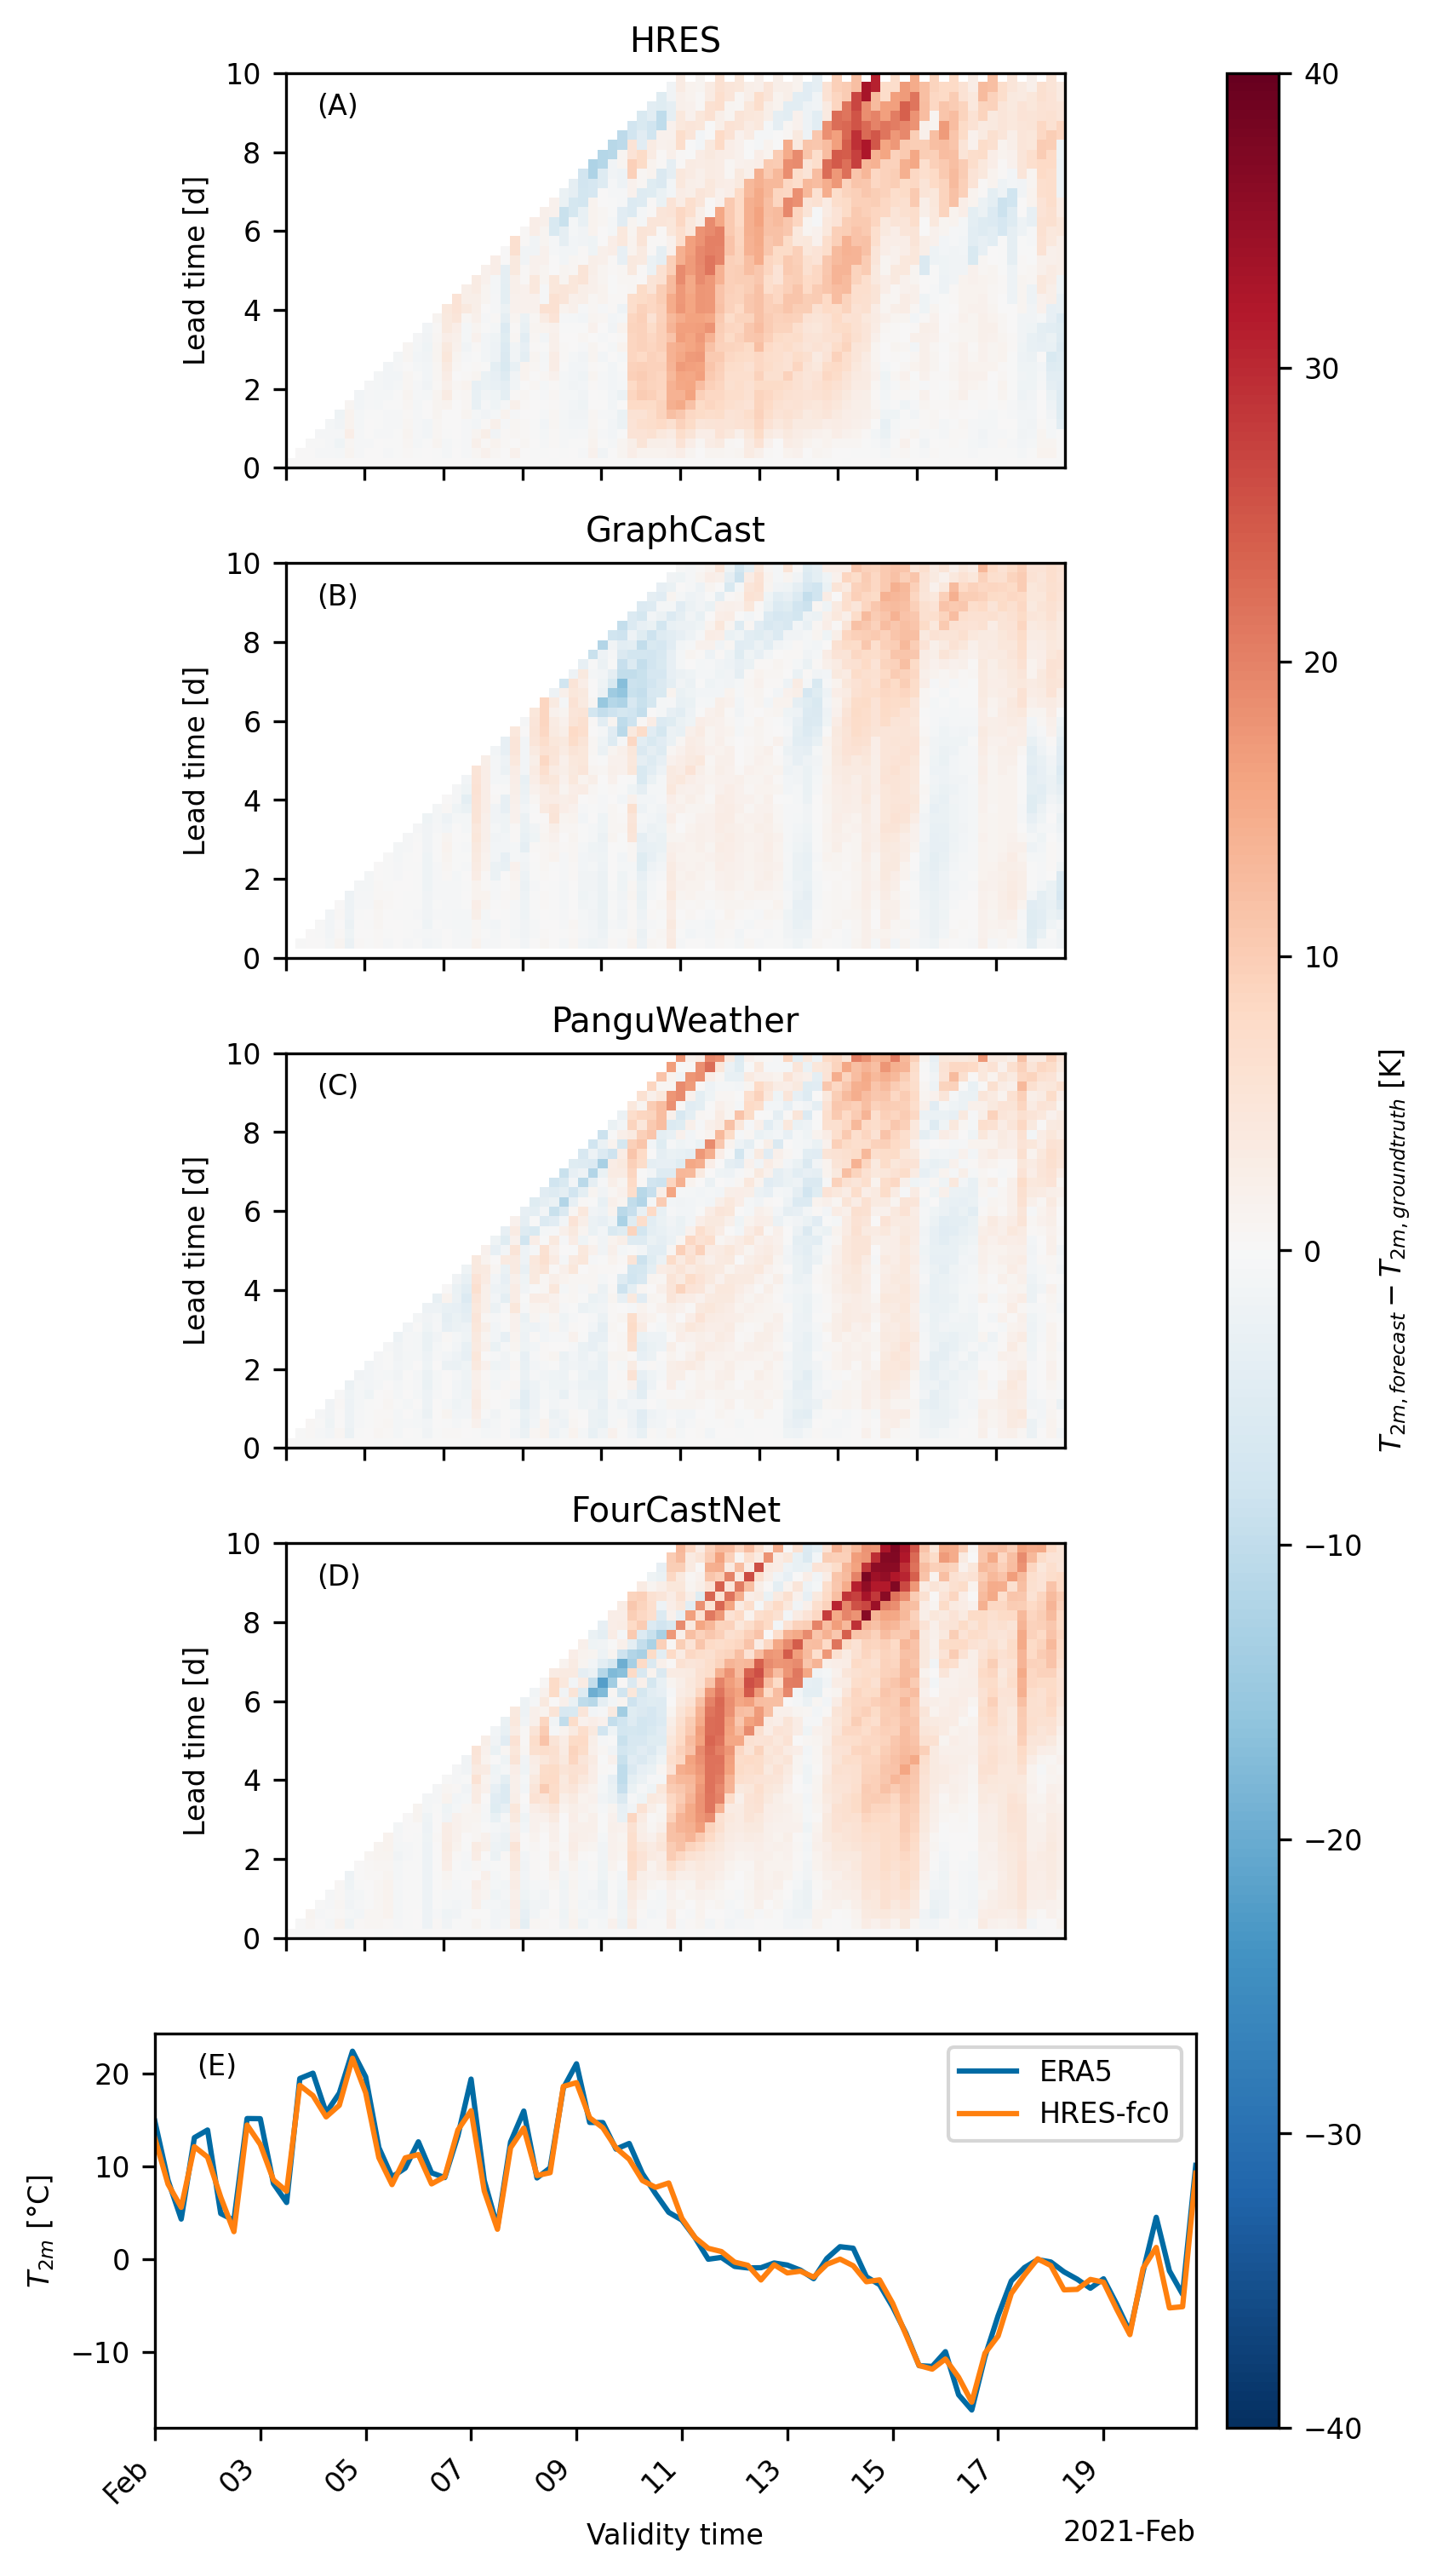

In [13]:
forecast_names = ["HRES", "GraphCast", "PanguWeather", "FourCastNet"]
ground_truth_names = ["HRES_t0", "ERA5", "ERA5", "ERA5"]

vmin = -40
vmax = 40
steps = 15

aspect_ratio_single_plot = 2.8
xticks_interval = 1

fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(fc_data.forecast) + 1),
    )
)
gs = gridspec.GridSpec(len(fc_data.forecast) + 1, 2, figure=fig, width_ratios=[1, 0.05])

for j, (fc_name, gt_name) in enumerate(
    zip(forecast_names, ground_truth_names, strict=False)
):
    ax = fig.add_subplot(gs[j, 0])

    d = get_data_for_barrier_plot(
        gt=gt_data.sel(source=gt_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["2m_temperature"]
        .compute(),
        fc=fc_data.sel(forecast=fc_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["2m_temperature"]
        .compute(),
    )

    d = d.assign_coords(
        prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
    )  # convert to number of days to make plotting nicer
    m = plt.imshow(
        d.T,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        extent=[
            d.valid_time[0].to_numpy(),
            d.valid_time[-1].to_numpy(),
            d.prediction_timedelta[0].to_numpy(),
            d.prediction_timedelta[-1].to_numpy(),
        ],
    )

    ax.set_xlabel("Validity time")

    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xlabel("")

    ax.set_ylabel("Lead time [d]")
    ax.set_title(f"{fc_name}")
    ax.set_aspect("equal")

    add_label_to_axes(ax, f"({letters[j]})")


ax_cbar = fig.add_subplot(gs[:, 1])
plt.colorbar(m, label="$T_{2m, forecast} - T_{2m, ground truth}$ [K]", cax=ax_cbar)
plt.tight_layout()

ax_ts = fig.add_subplot(gs[-1, 0])

kelvin_to_celsius(gt_data["2m_temperature"]).sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="ERA5").plot(ax=ax_ts, label="ERA5")

kelvin_to_celsius(gt_data["2m_temperature"]).sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="HRES_t0").plot(ax=ax_ts, label="HRES-fc0")

ax_ts.set_title("")
ax_ts.set_ylabel(r"$T_{2m}$ [°C]")
ax_ts.set_xlabel("Validity time")
ax_ts.set_xlim(d.valid_time.to_numpy()[[0, -1]])
plt.xticks(rotation=45, ha="right")
ax_ts.legend()
add_label_to_axes(ax_ts, f"({letters[len(ground_truth_names)]})")
plt.tight_layout()

plt.savefig("images/2021_NA_winterstorm_predictability_barrier_2m_temperature.png")

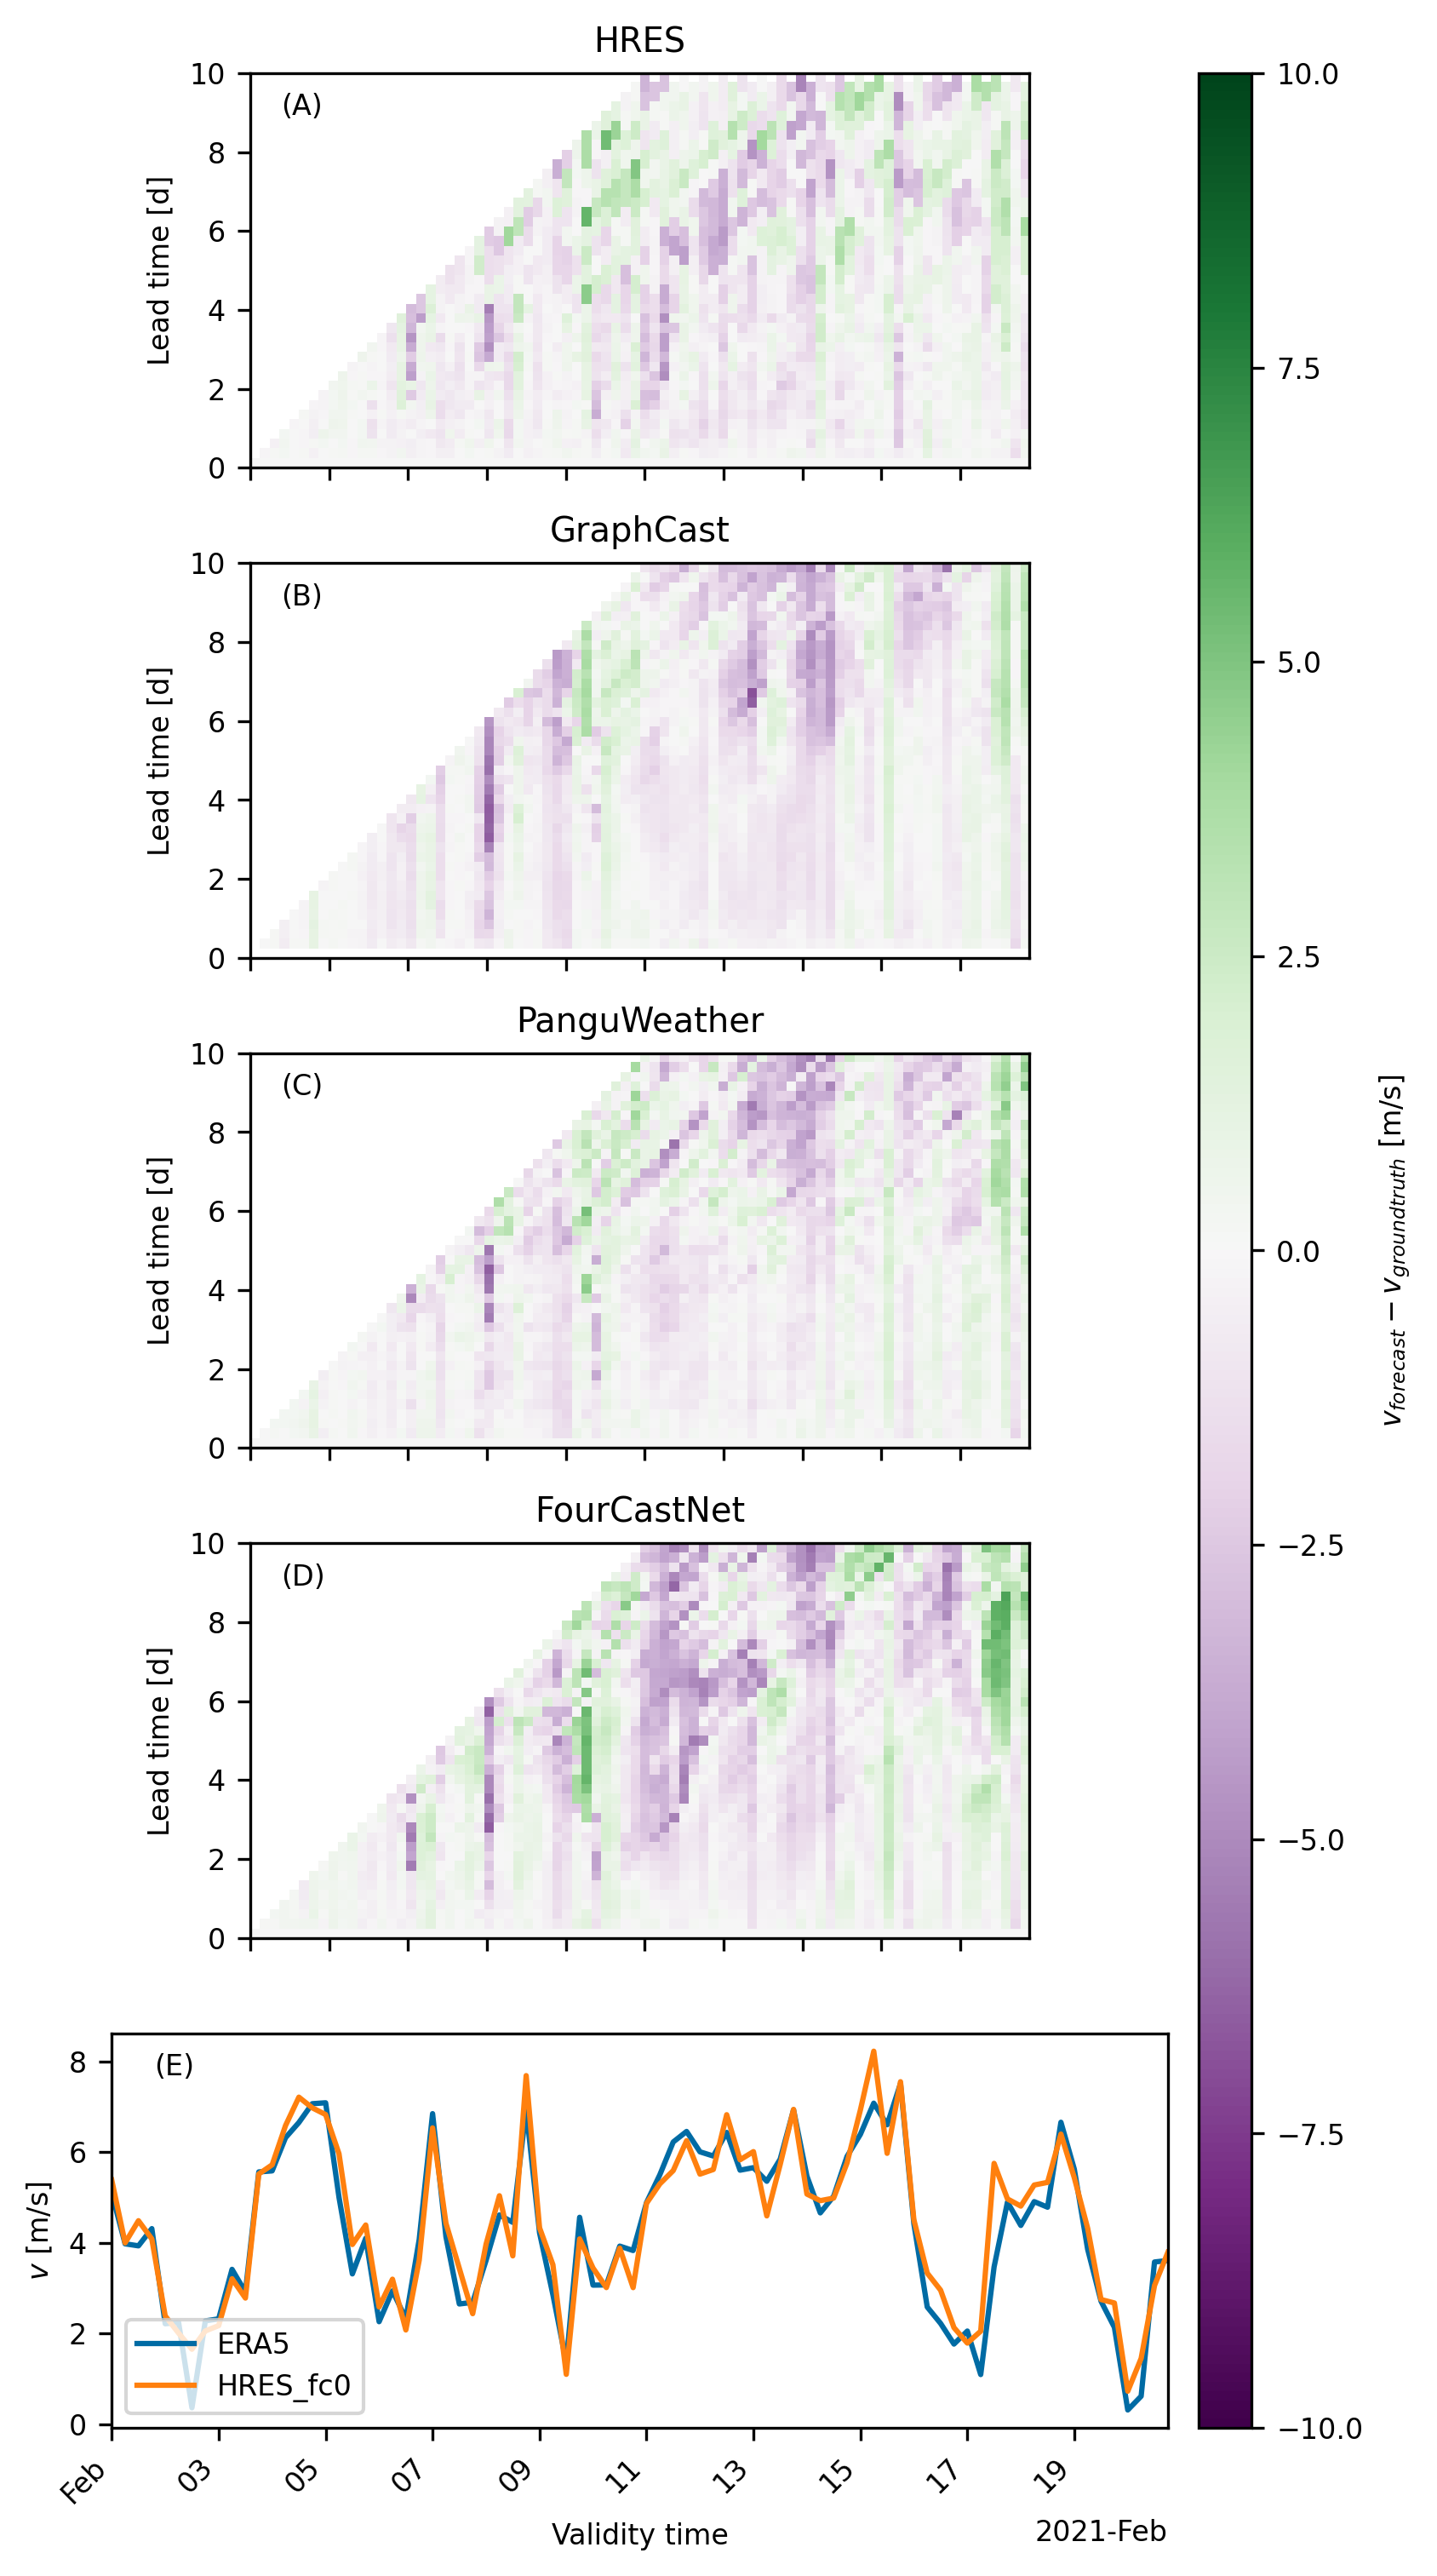

In [14]:
forecast_names = ["HRES", "GraphCast", "PanguWeather", "FourCastNet"]
ground_truth_names = ["HRES_t0", "ERA5", "ERA5", "ERA5"]

vmin = -10
vmax = 10
steps = 15

aspect_ratio_single_plot = 2.8
xticks_interval = 1

fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(fc_data.forecast) + 1),
    )
)
gs = gridspec.GridSpec(len(fc_data.forecast) + 1, 2, figure=fig, width_ratios=[1, 0.05])

for j, (fc_name, gt_name) in enumerate(
    zip(forecast_names, ground_truth_names, strict=False)
):
    ax = fig.add_subplot(gs[j, 0])

    d = get_data_for_barrier_plot(
        gt=gt_data.sel(source=gt_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["surface_windspeed"]
        .compute(),
        fc=fc_data.sel(forecast=fc_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["surface_windspeed"]
        .compute(),
    )

    d = d.assign_coords(
        prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
    )  # convert to number of days to make plotting nicer

    m = plt.imshow(
        d.T,
        cmap="PRGn",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        extent=[
            d.valid_time[0].to_numpy(),
            d.valid_time[-1].to_numpy(),
            d.prediction_timedelta[0].to_numpy(),
            d.prediction_timedelta[-1].to_numpy(),
        ],
    )

    ax.set_xlabel("Validity time")

    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xlabel("")

    ax.set_ylabel("Lead time [d]")
    ax.set_title(f"{fc_name}")
    ax.set_aspect("equal")

    add_label_to_axes(ax, f"({letters[j]})")

ax_cbar = fig.add_subplot(gs[:, 1])
plt.colorbar(m, label=r"$v_{forecast} - v_{ground truth}$ [m/s]", cax=ax_cbar)
plt.tight_layout()

ax_ts = fig.add_subplot(gs[-1, 0])


gt_data["surface_windspeed"].sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="ERA5").plot(ax=ax_ts, label="ERA5")

gt_data["surface_windspeed"].sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="HRES_t0").plot(ax=ax_ts, label="HRES_fc0")

ax_ts.set_title("")
ax_ts.set_ylabel(r"$v$ [m/s]")
ax_ts.set_xlabel("Validity time")
ax_ts.set_xlim(d.valid_time.to_numpy()[[0, -1]])
ax_ts.legend(loc="lower left")
plt.xticks(rotation=45, ha="right")
add_label_to_axes(ax_ts, f"({letters[len(ground_truth_names)]})")

plt.tight_layout()

plt.savefig("images/2021_NA_winterstorm_predictability_barrier_surface_windspeed.png")

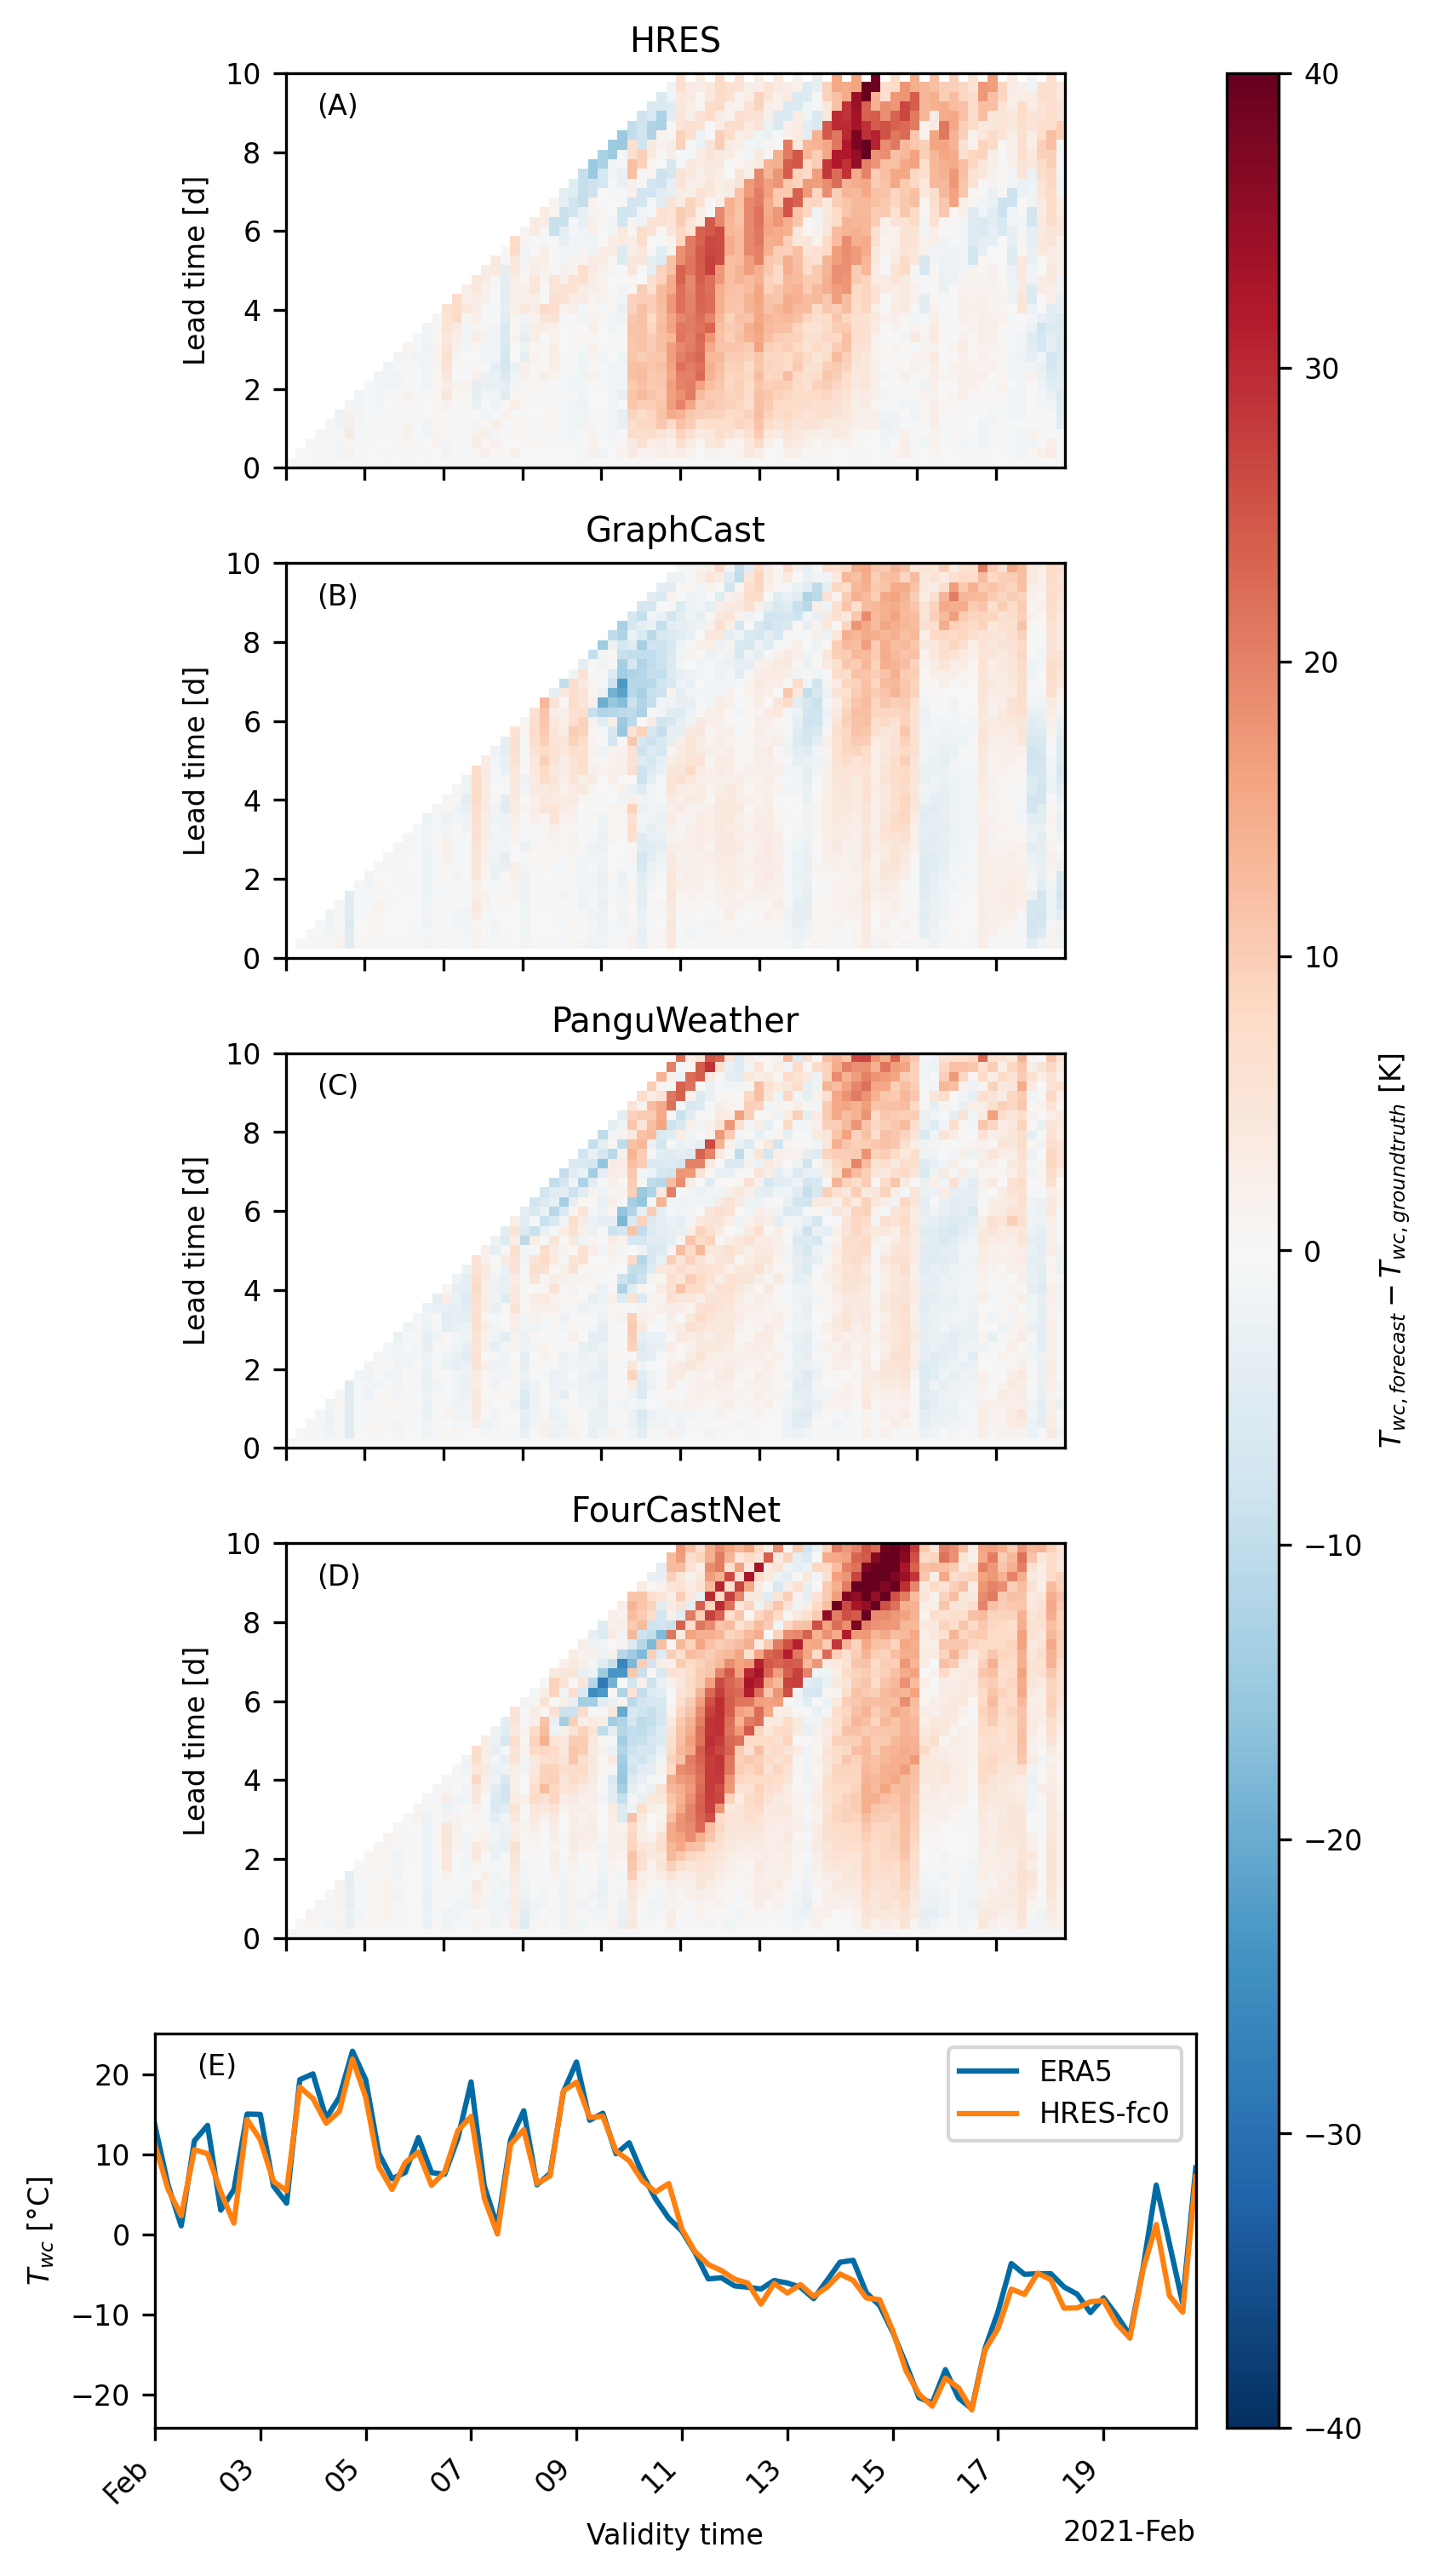

In [15]:
forecast_names = ["HRES", "GraphCast", "PanguWeather", "FourCastNet"]
ground_truth_names = ["HRES_t0", "ERA5", "ERA5", "ERA5"]

vmin = -40
vmax = 40
steps = 15

aspect_ratio_single_plot = 2.8
xticks_interval = 1

fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(fc_data.forecast) + 1),
    )
)
gs = gridspec.GridSpec(len(fc_data.forecast) + 1, 2, figure=fig, width_ratios=[1, 0.05])

for j, (fc_name, gt_name) in enumerate(
    zip(forecast_names, ground_truth_names, strict=False)
):
    ax = fig.add_subplot(gs[j, 0])

    d = get_data_for_barrier_plot(
        gt=gt_data.sel(source=gt_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["wind_chill"]
        .compute(),
        fc=fc_data.sel(forecast=fc_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["wind_chill"]
        .compute(),
    )

    d = d.assign_coords(
        prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
    )  # convert to number of days to make plotting nicer

    m = plt.imshow(
        d.T,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        extent=[
            d.valid_time[0].to_numpy(),
            d.valid_time[-1].to_numpy(),
            d.prediction_timedelta[0].to_numpy(),
            d.prediction_timedelta[-1].to_numpy(),
        ],
    )

    ax.set_xlabel("Validity time")
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xlabel("")

    ax.set_ylabel("Lead time [d]")
    ax.set_title(f"{fc_name}")
    ax.set_aspect("equal")

    add_label_to_axes(ax, f"({letters[j]})")


ax_cbar = fig.add_subplot(gs[:, 1])
plt.colorbar(m, label="$T_{wc, forecast} - T_{wc, ground truth}$ [K]", cax=ax_cbar)
plt.tight_layout()

ax_ts = fig.add_subplot(gs[-1, 0])

gt_data["wind_chill"].sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="ERA5").plot(ax=ax_ts, label="ERA5")

gt_data["wind_chill"].sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="HRES_t0").plot(ax=ax_ts, label="HRES-fc0")

ax_ts.set_title("")
ax_ts.set_ylabel(r"$T_{wc}$ [°C]")
ax_ts.set_xlabel("Validity time")
ax_ts.set_xlim(d.valid_time.to_numpy()[[0, -1]])
ax_ts.legend()
plt.xticks(rotation=45, ha="right")
add_label_to_axes(ax_ts, f"({letters[len(ground_truth_names)]})")
plt.tight_layout()

plt.savefig("images/2021_NA_winterstorm_predictability_barrier_wind_chill.png")

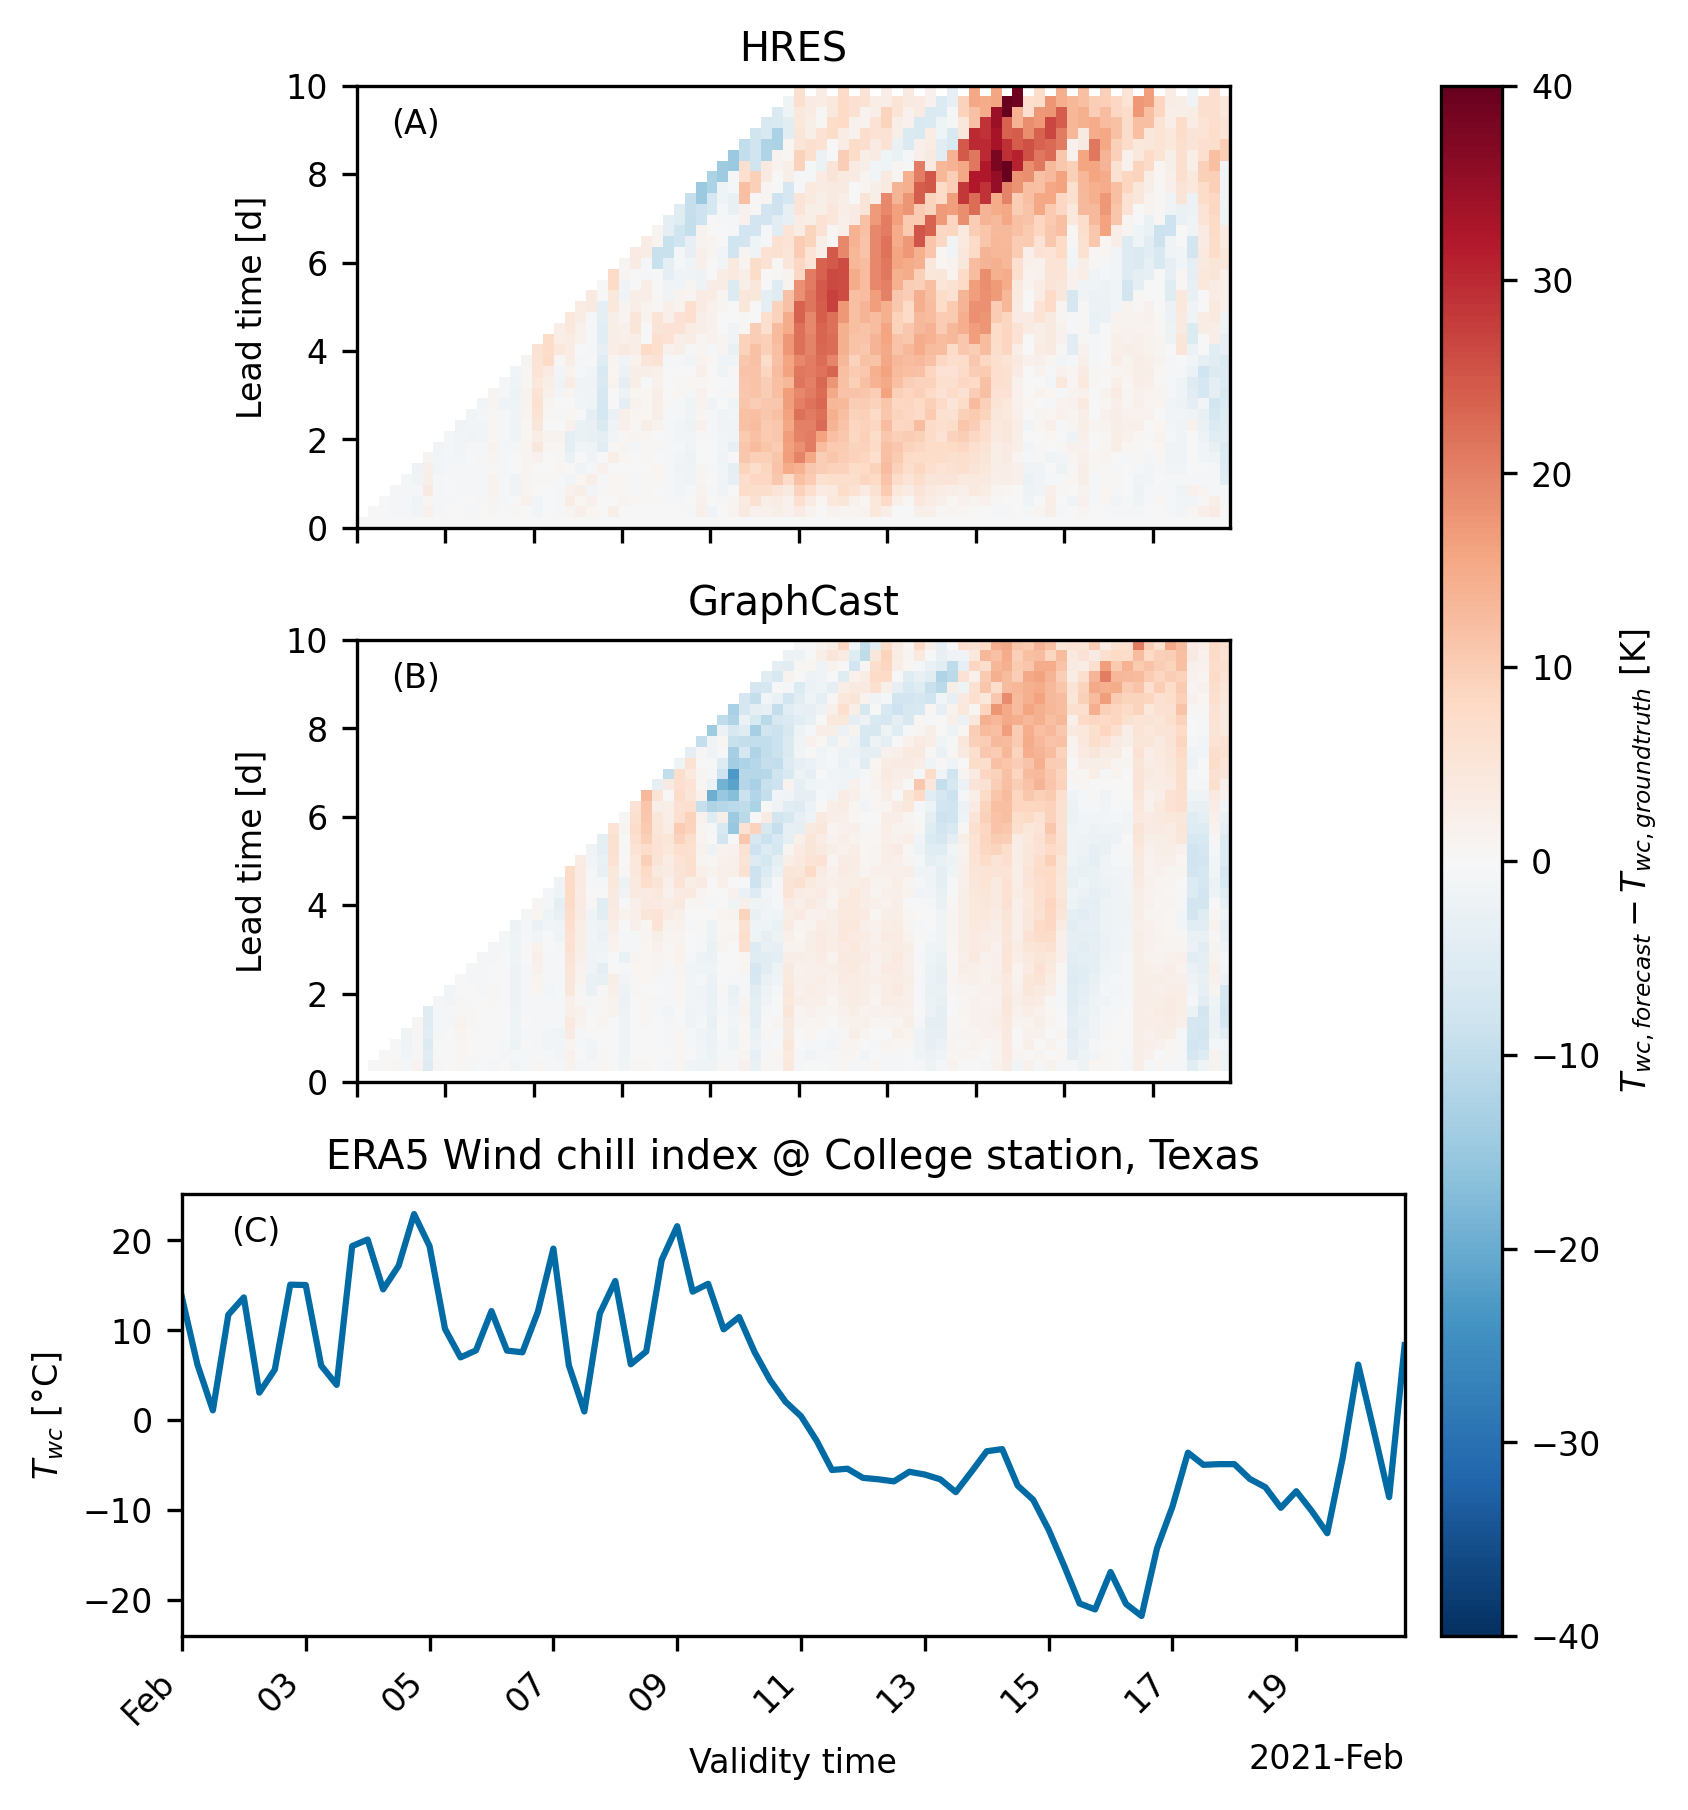

In [16]:
forecast_names = ["HRES", "GraphCast"]
ground_truth_names = ["HRES_t0", "ERA5"]

vmin = -40
vmax = 40
steps = 15

aspect_ratio_single_plot = 2.8
xticks_interval = 1

fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (2 + 1),
    )
)
gs = gridspec.GridSpec(2 + 1, 2, figure=fig, width_ratios=[1, 0.05])

for j, (fc_name, gt_name) in enumerate(
    zip(forecast_names, ground_truth_names, strict=False)
):
    ax = fig.add_subplot(gs[j, 0])

    d = get_data_for_barrier_plot(
        gt=gt_data.sel(source=gt_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["wind_chill"]
        .compute(),
        fc=fc_data.sel(forecast=fc_name)
        .sel(
            {
                "latitude": college_station_coords["latitude"],
                "longitude": college_station_coords["longitude"],
            },
            method="nearest",
        )["wind_chill"]
        .compute(),
    )

    d = d.assign_coords(
        prediction_timedelta=d.prediction_timedelta / np.timedelta64(1, "D")
    )  # convert to number of days to make plotting nicer

    m = plt.imshow(
        d.T,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        extent=[
            d.valid_time[0].to_numpy(),
            d.valid_time[-1].to_numpy(),
            d.prediction_timedelta[0].to_numpy(),
            d.prediction_timedelta[-1].to_numpy(),
        ],
    )

    ax.set_xlabel("Validity time")
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xlabel("")

    ax.set_ylabel("Lead time [d]")
    ax.set_title(f"{fc_name}")
    ax.set_aspect("equal")

    add_label_to_axes(ax, f"({letters[j]})")

ax_cbar = fig.add_subplot(gs[:, 1])
plt.colorbar(m, label="$T_{wc, forecast} - T_{wc, ground truth}$ [K]", cax=ax_cbar)
plt.tight_layout()

ax_ts = fig.add_subplot(gs[-1, 0])

gt_data["wind_chill"].sel(time=d.valid_time.to_numpy()).sel(
    college_station_coords, method="nearest"
).sel(source="ERA5").plot(ax=ax_ts, label="ERA5")

# gt_data["wind_chill"].sel(time=d.valid_time.to_numpy()).sel(
#     college_station_coords, method="nearest"
# ).sel(source="HRES_t0").plot(ax=ax_ts, label="HRES-fc0")

ax_ts.set_title("ERA5 Wind chill index @ College station, Texas")
ax_ts.set_ylabel(r"$T_{wc}$ [°C]")
ax_ts.set_xlabel("Validity time")
ax_ts.set_xlim(d.valid_time.to_numpy()[[0, -1]])
# ax_ts.legend()
plt.xticks(rotation=45, ha="right")
add_label_to_axes(ax_ts, f"({letters[len(ground_truth_names)]})")

plt.tight_layout()

plt.savefig("images/2021_NA_winterstorm_predictability_barrier_wind_chill_small.png")

# Test if this is a local result.

To test if the main characteristic of this result ("GraphCast and Pangu are better than HRES for the peak of the winter storm"), we can show a map plot of the forecast biases at the time of mimimum wind chill

## Step 1:

Get time series of wind chill (averaged over Texas)

In [17]:
i_min = (
    gt_data["wind_chill"]
    .sel(source="ERA5")
    .sel(bb_texas)
    .mean(("latitude", "longitude"))
    .argmin()
    .to_numpy()
)
t_min = gt_data.time.isel(time=i_min).to_numpy()

forecast_names = ["HRES", "GraphCast", "PanguWeather", "FourCastNet"]
ground_truth_names = ["HRES_t0", "ERA5", "ERA5", "ERA5"]

## Step 2:

Calculate and plot wind chill forecast - wind chill observed for different lead times.

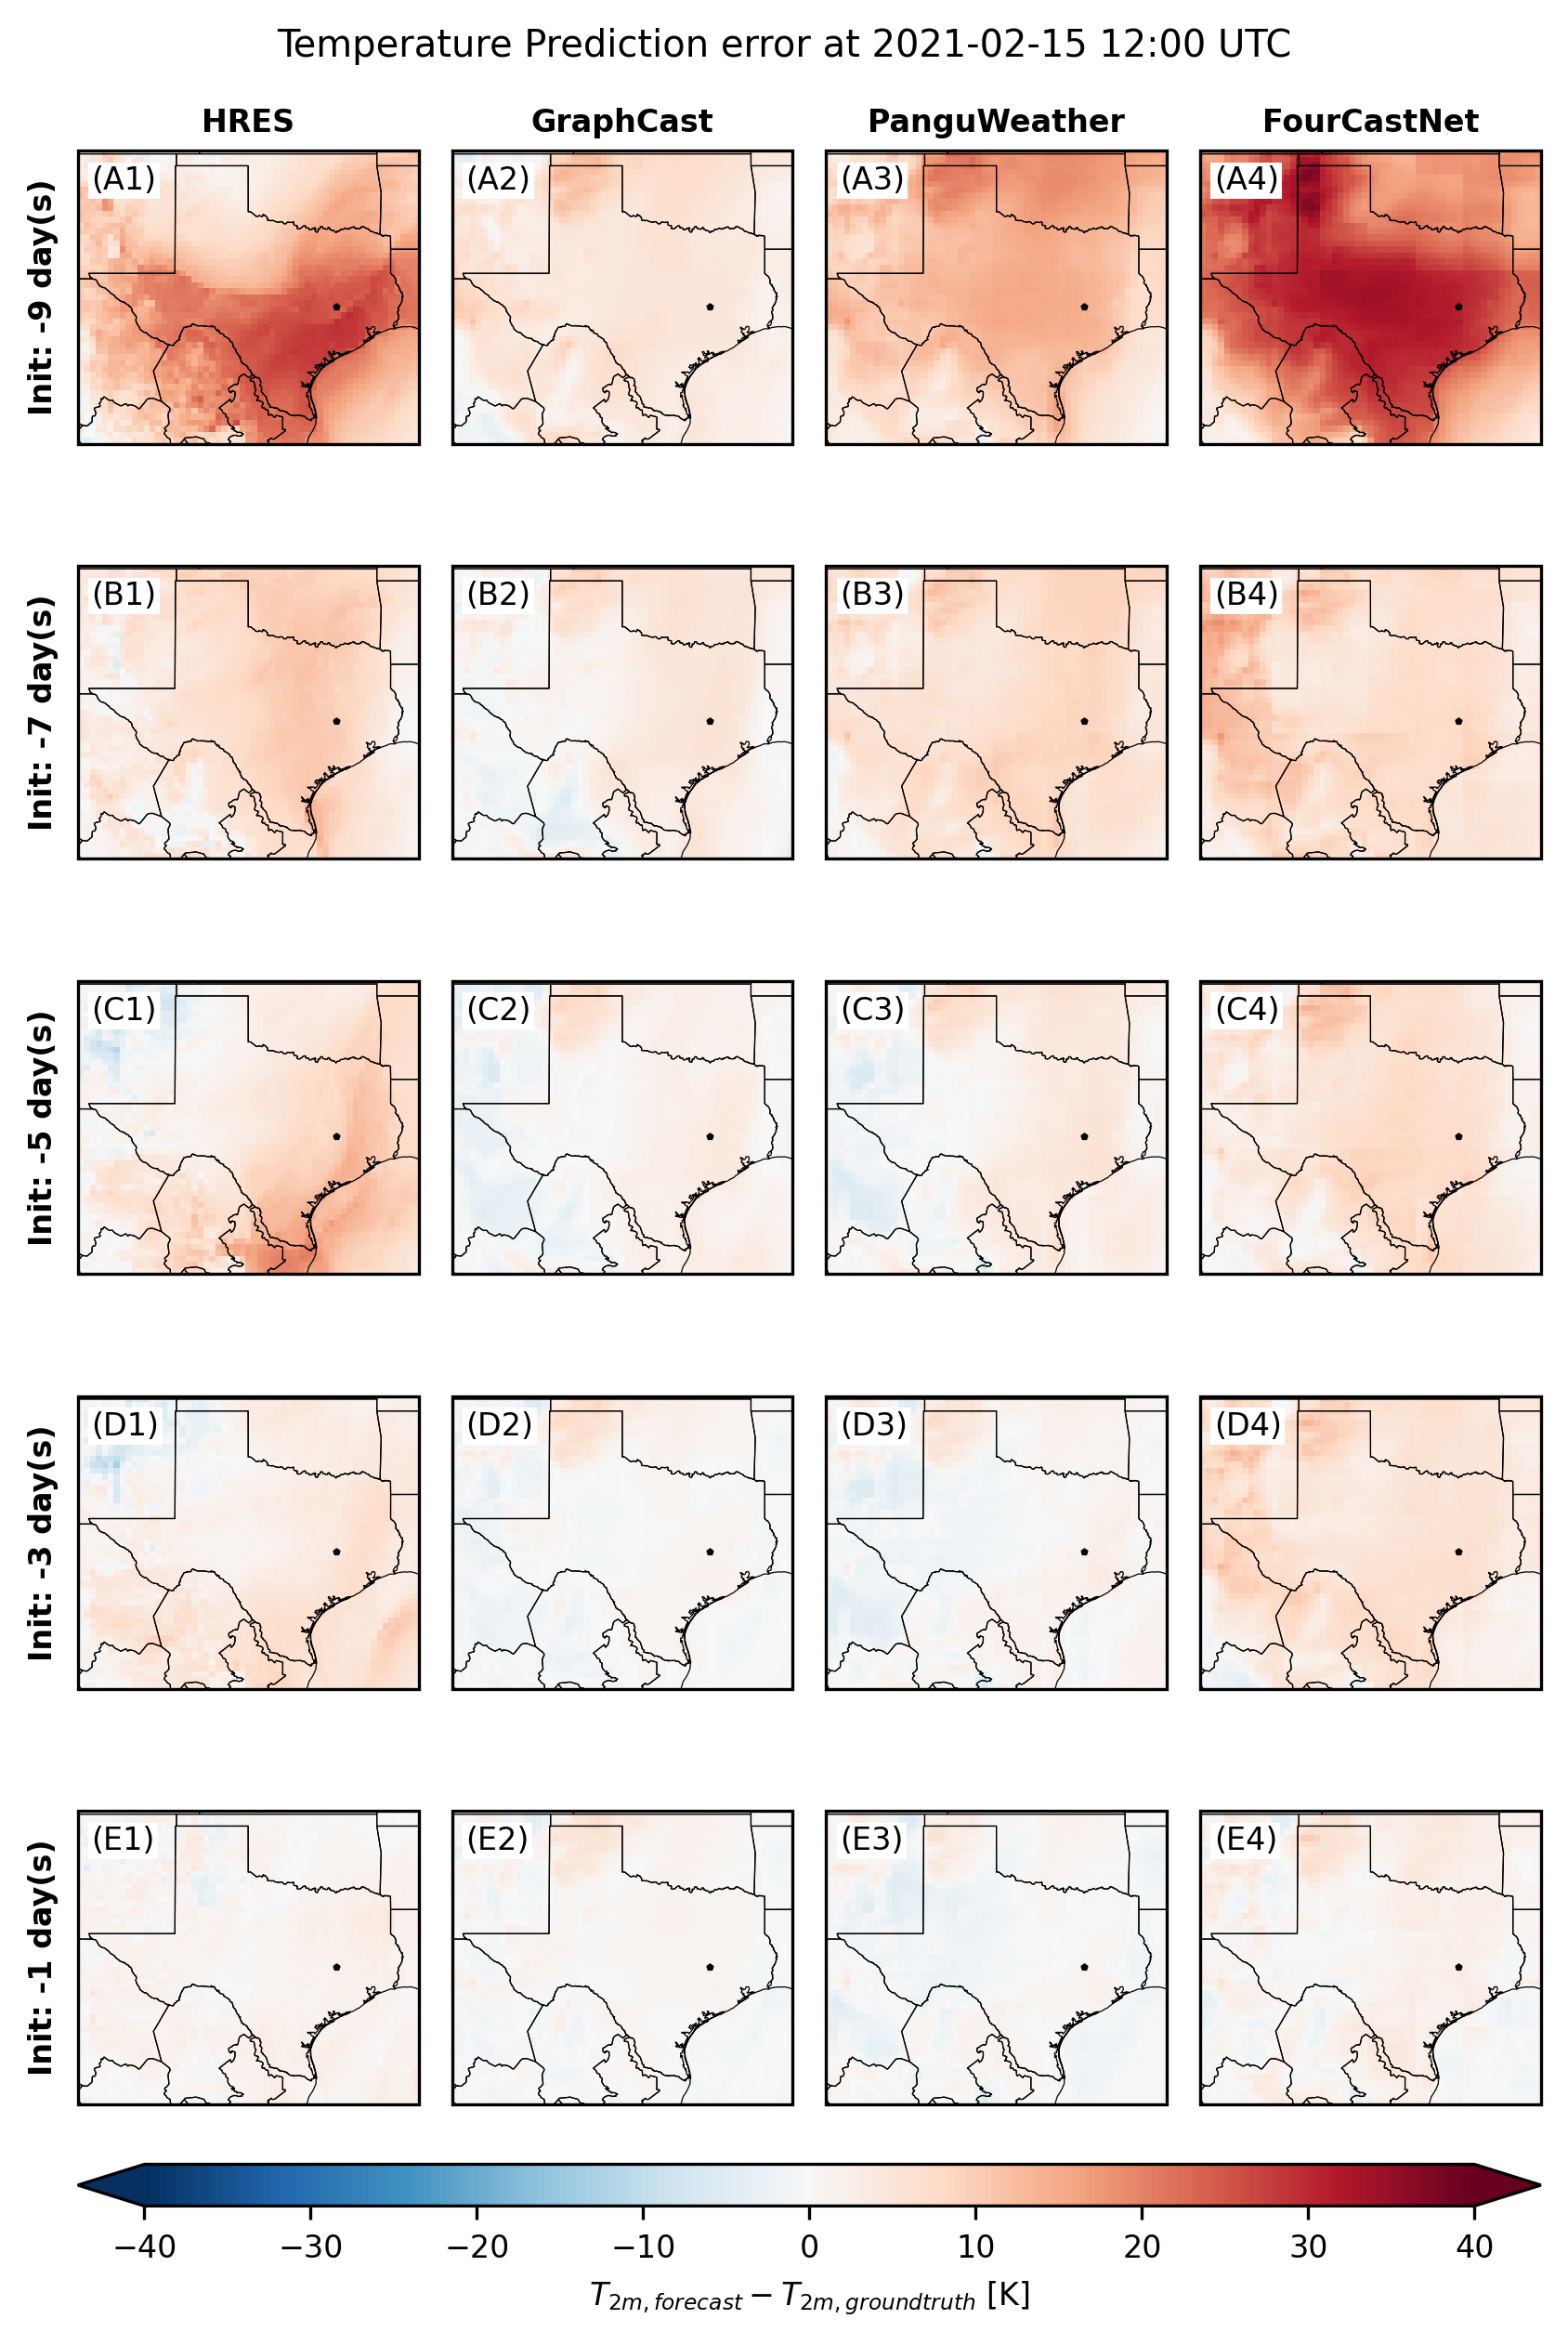

In [18]:
n_days = np.flip(np.array([1, 3, 5, 7, 9]))
start_dates = t_min - n_days * np.timedelta64(1, "D")

vmin = -40
vmax = 40

aspect_ratio_single_plot = 1
fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(start_dates) + 1) / 4,
    )
)
gs = gridspec.GridSpec(
    len(start_dates) + 1,
    4,
    figure=fig,
    height_ratios=(len(start_dates)) * [1] + [0.1],
)

for i, start_date in enumerate(start_dates):
    for j, (fc_name, gt_name) in enumerate(
        zip(forecast_names, ground_truth_names, strict=False)
    ):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())

        gt = (
            gt_data["2m_temperature"]
            .sel(source=gt_name)
            .sel(bb_texas)
            .sel({"time": t_min})
        )
        fc = fc_data["2m_temperature"].sel(time=start_date)
        fc = (
            fc.where(fc.valid_time.compute() == t_min, drop=True)
            .sel(forecast=fc_name)
            .sel(bb_texas)
        )

        m = (fc - gt).plot(
            ax=ax, vmin=vmin, vmax=vmax, cmap="RdBu_r", add_colorbar=False
        )
        ax.scatter(
            *reversed(list(college_station_coords.values())), s=1, marker="*", c="k"
        )

        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="k")

        ax.set_title("")
        add_label_to_axes(ax, f"({letters[i]}{j+1})")

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m, forecast} - T_{2m, ground truth}$ [K]",
    orientation="horizontal",
    extend="both",
)

add_headers(
    fig=fig,
    col_headers=forecast_names,
    row_headers=[f"Init: -{nd} day(s)" for nd in n_days] + [""],
    fontweight="bold",
)

fig.suptitle(
    f"Temperature Prediction error at {pd.Timestamp(t_min.item()).date()} {pd.Timestamp(t_min.item()).hour:02d}:00 UTC"
)

plt.tight_layout()
plt.savefig(
    "images/2021_NA_winterstorm_prediction_error_temperature_at_minimum_windchill.png"
)

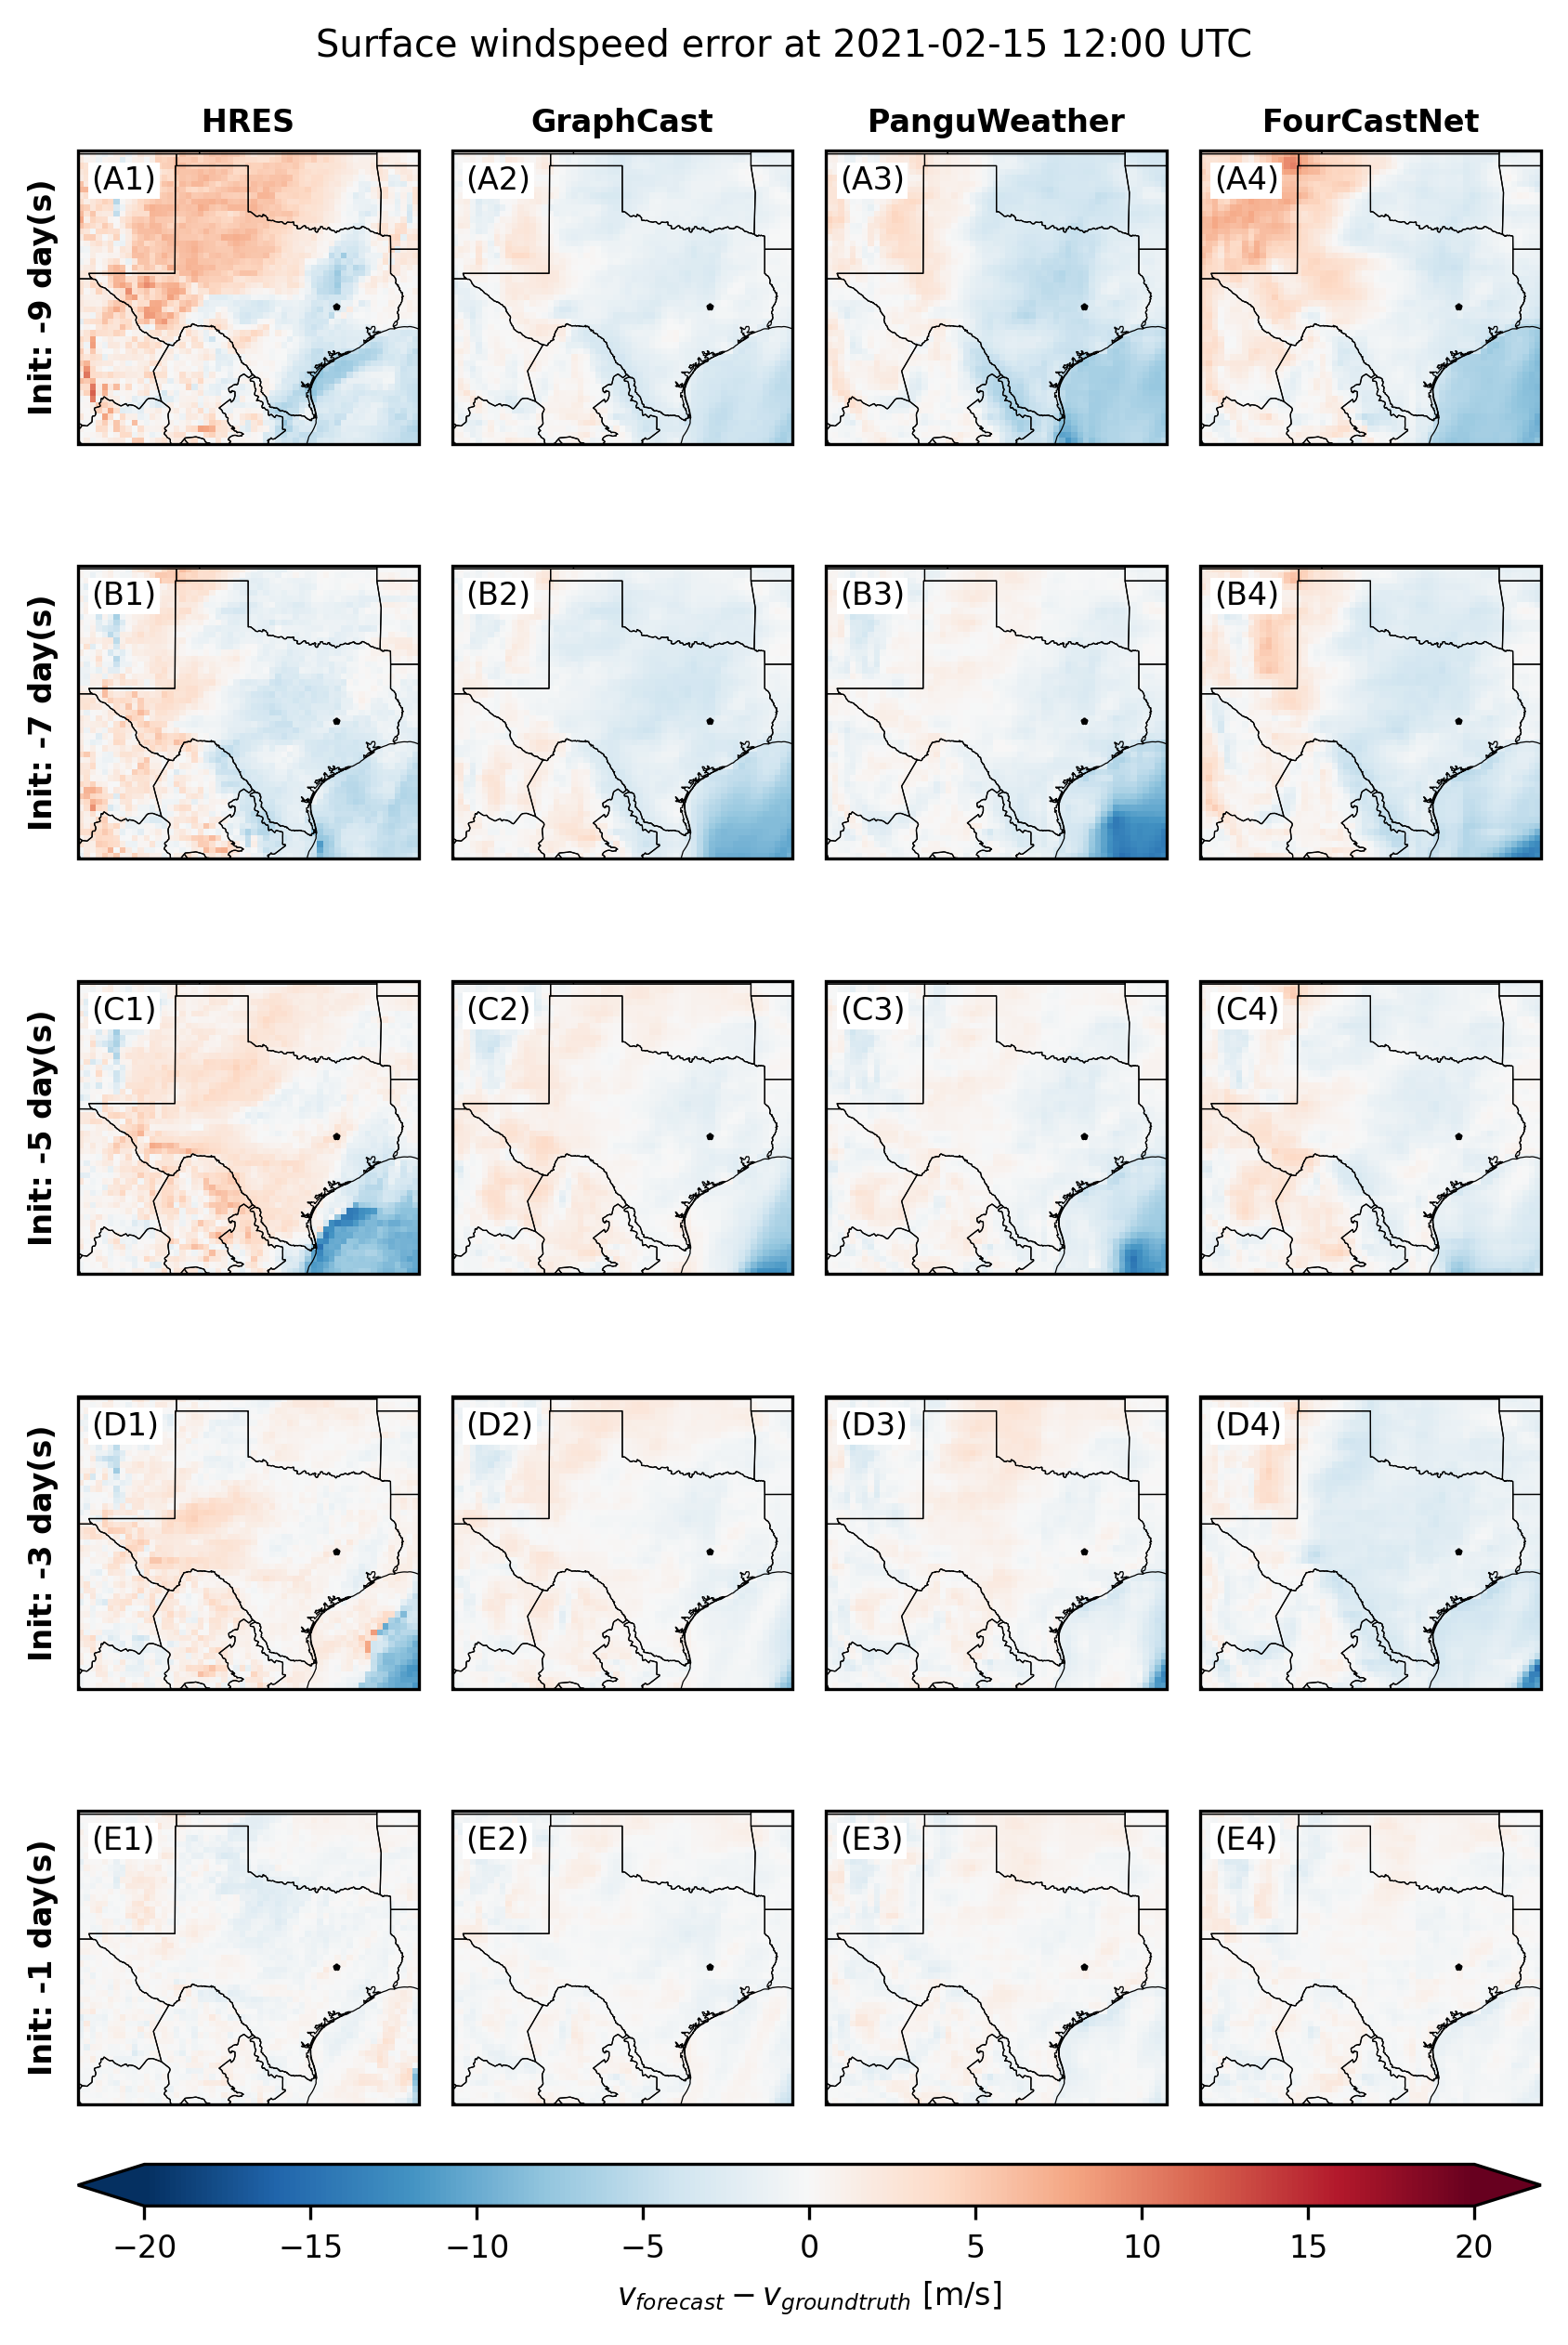

In [19]:
n_days = np.flip(np.array([1, 3, 5, 7, 9]))
start_dates = t_min - n_days * np.timedelta64(1, "D")

vmin = -20
vmax = 20

aspect_ratio_single_plot = 1
fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(start_dates) + 1) / 4,
    )
)
gs = gridspec.GridSpec(
    len(start_dates) + 1,
    4,
    figure=fig,
    height_ratios=(len(start_dates)) * [1] + [0.1],
)

for i, start_date in enumerate(start_dates):
    for j, (fc_name, gt_name) in enumerate(
        zip(forecast_names, ground_truth_names, strict=False)
    ):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())

        gt = (
            gt_data["surface_windspeed"]
            .sel(source=gt_name)
            .sel(bb_texas)
            .sel({"time": t_min})
        )
        fc = fc_data["surface_windspeed"].sel(time=start_date)
        fc = (
            fc.where(fc.valid_time.compute() == t_min, drop=True)
            .sel(forecast=fc_name)
            .sel(bb_texas)
        )

        m = (fc - gt).plot(
            ax=ax, vmin=vmin, vmax=vmax, cmap="RdBu_r", add_colorbar=False
        )
        ax.scatter(
            *reversed(list(college_station_coords.values())), s=1, marker="*", c="k"
        )

        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="k")

        ax.set_title("")
        add_label_to_axes(ax, f"({letters[i]}{j+1})")

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    m,
    cax=ax_cbar,
    label="$v_{forecast} - v_{ground truth}$ [m/s]",
    orientation="horizontal",
    extend="both",
)

add_headers(
    fig=fig,
    col_headers=forecast_names,
    row_headers=[f"Init: -{nd} day(s)" for nd in n_days] + [""],
    fontweight="bold",
)

fig.suptitle(
    f"Surface windspeed error at {pd.Timestamp(t_min.item()).date()} {pd.Timestamp(t_min.item()).hour:02d}:00 UTC"
)

plt.tight_layout()
plt.savefig(
    "images/2021_NA_winterstorm_prediction_error_windspeed_at_minimum_windchill.png"
)

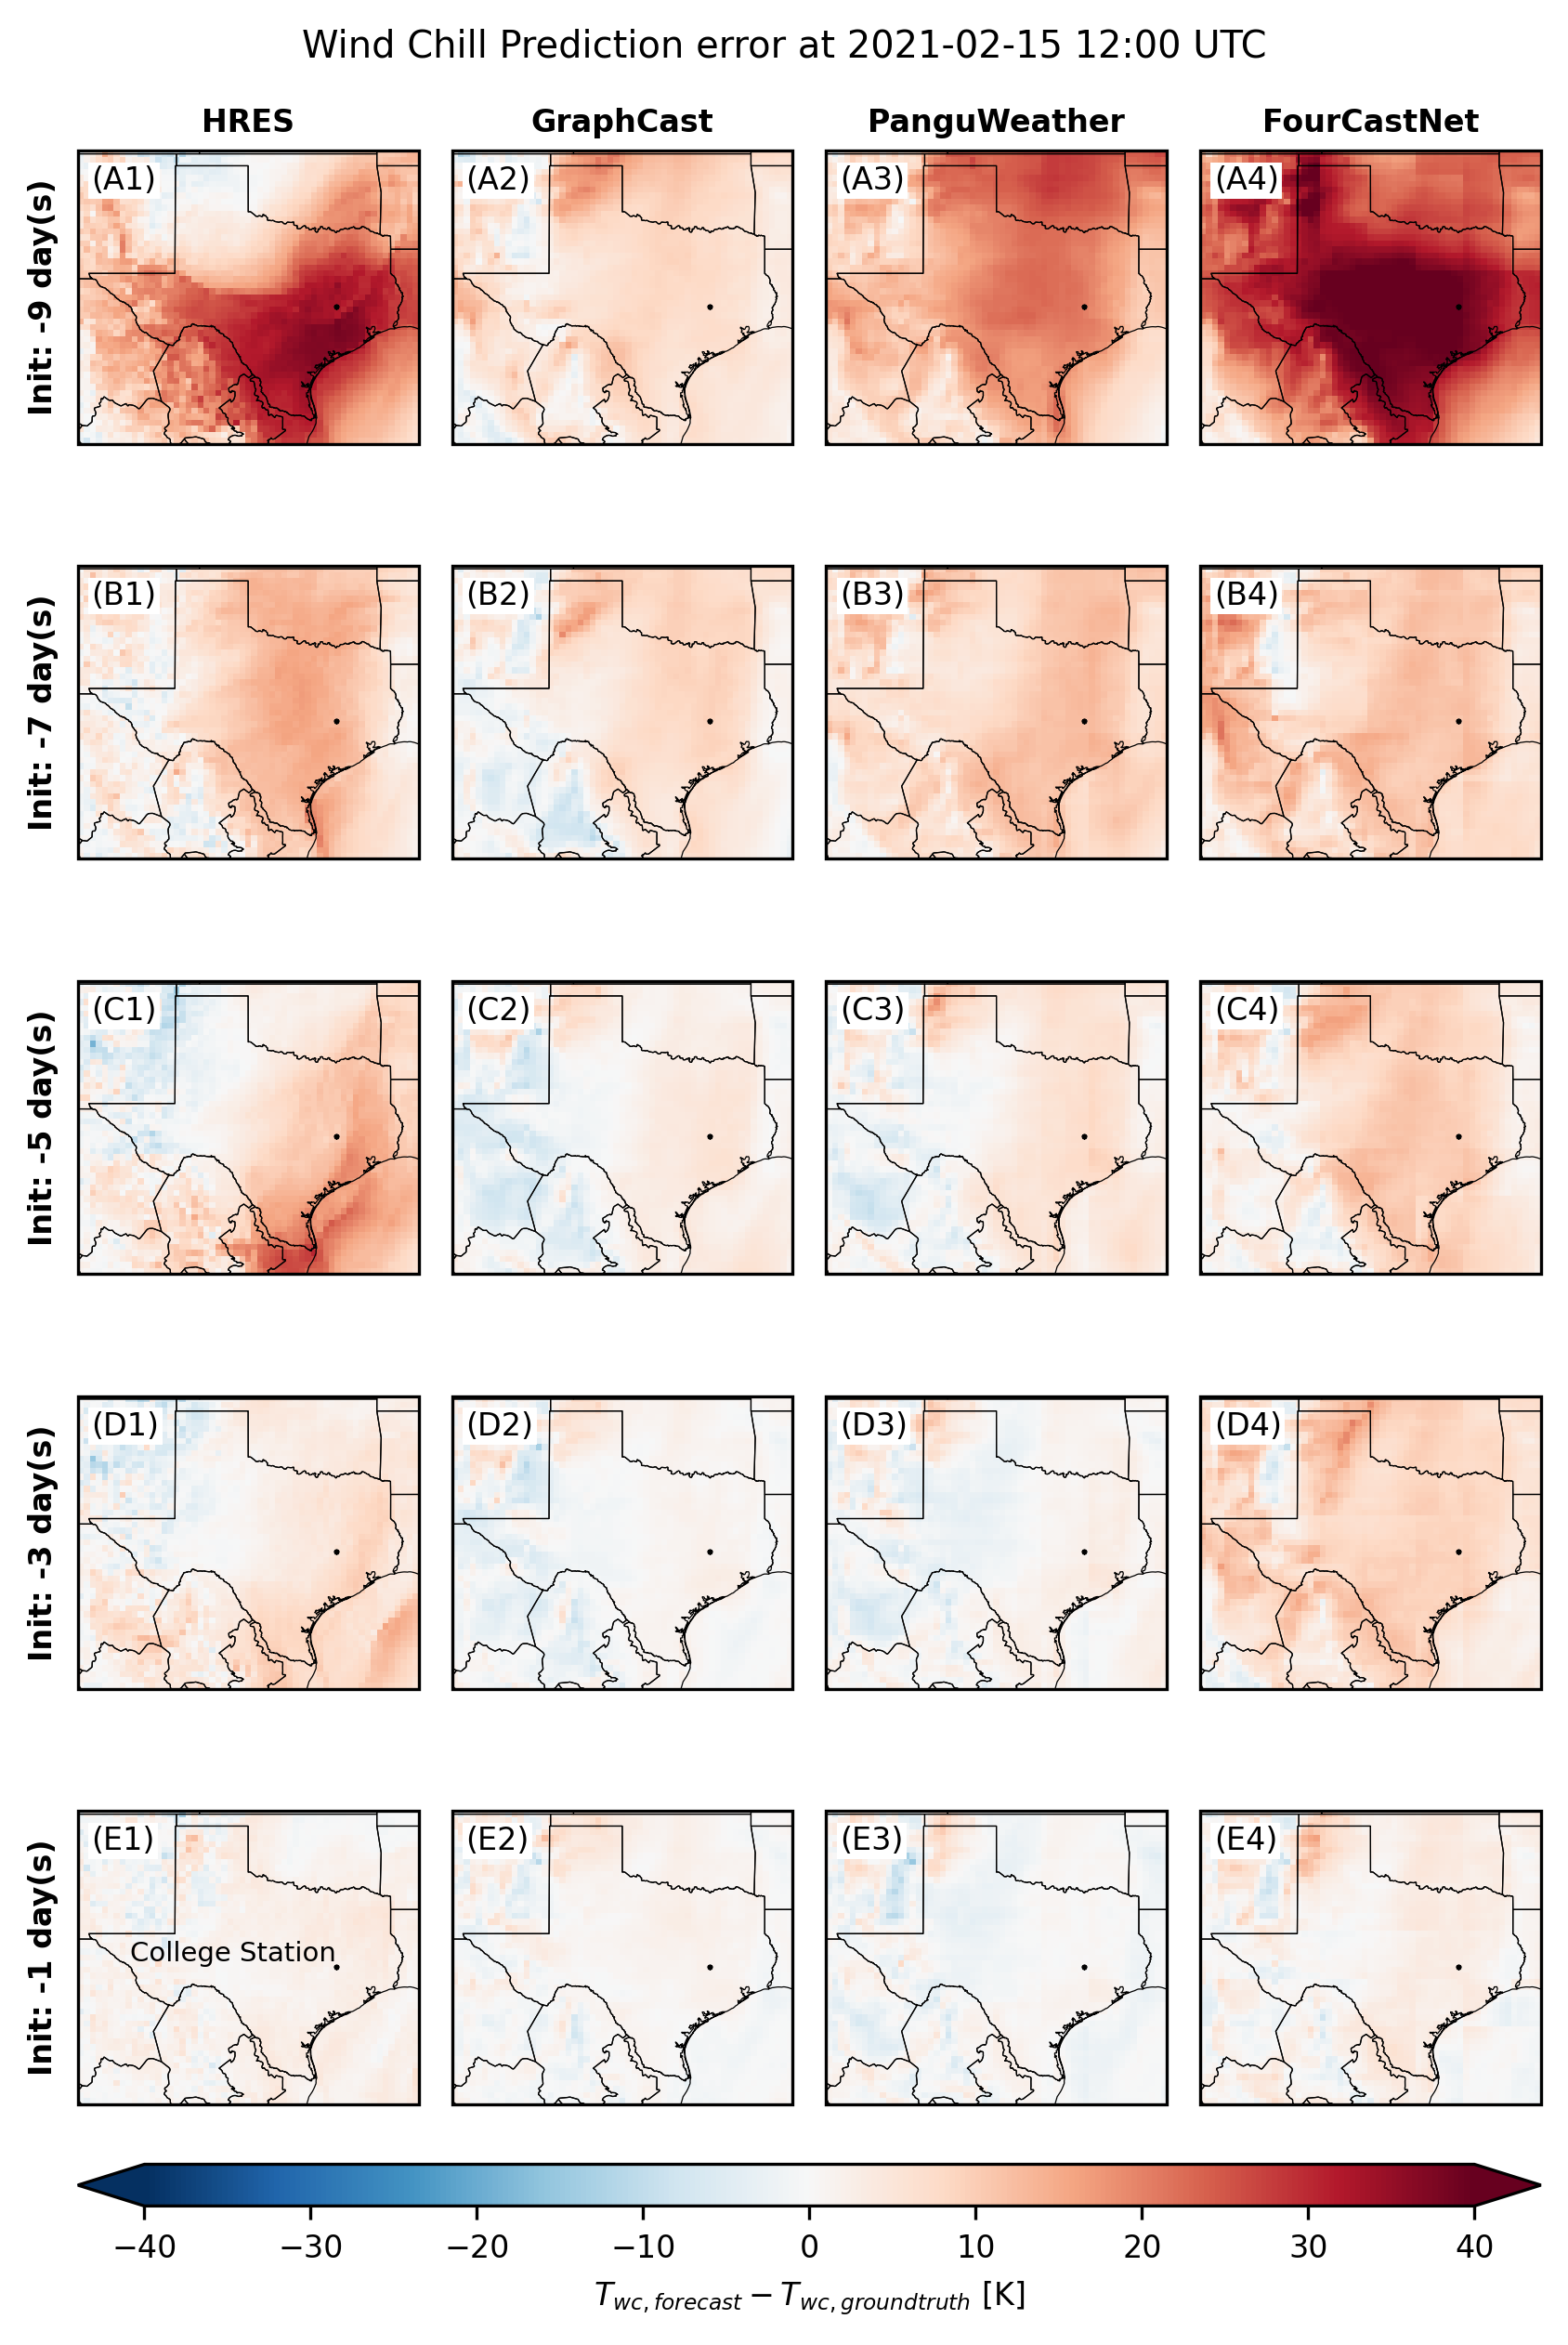

In [20]:
n_days = np.flip(np.array([1, 3, 5, 7, 9]))
start_dates = t_min - n_days * np.timedelta64(1, "D")

vmin = -40
vmax = 40

aspect_ratio_single_plot = 1
fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(start_dates) + 1) / 4,
    )
)
gs = gridspec.GridSpec(
    len(start_dates) + 1,
    4,
    figure=fig,
    height_ratios=(len(start_dates)) * [1] + [0.1],
)

for i, start_date in enumerate(start_dates):
    for j, (fc_name, gt_name) in enumerate(
        zip(forecast_names, ground_truth_names, strict=False)
    ):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())

        gt = (
            gt_data["wind_chill"].sel(source=gt_name).sel(bb_texas).sel({"time": t_min})
        )
        fc = fc_data["wind_chill"].sel(time=start_date)
        fc = (
            fc.where(fc.valid_time.compute() == t_min, drop=True)
            .sel(forecast=fc_name)
            .sel(bb_texas)
        )

        m = (fc - gt).plot(
            ax=ax, vmin=vmin, vmax=vmax, cmap="RdBu_r", add_colorbar=False
        )
        ax.scatter(
            *reversed(list(college_station_coords.values())), s=0.3, marker="*", c="k"
        )

        if i == 4 and j == 0:
            ax.annotate(
                "College Station",
                tuple(reversed(list(college_station_coords.values()))),
                color="k",
                fontsize=7,
                horizontalalignment="right",
                verticalalignment="bottom",
            )

        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="k")

        ax.set_title("")

        add_label_to_axes(ax, f"({letters[i]}{j+1})")

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{wc, forecast} - T_{wc, ground truth}$ [K]",
    orientation="horizontal",
    extend="both",
)

add_headers(
    fig=fig,
    col_headers=forecast_names,
    row_headers=[f"Init: -{nd} day(s)" for nd in n_days] + [""],
    fontweight="bold",
)

fig.suptitle(
    f"Wind Chill Prediction error at {pd.Timestamp(t_min.item()).date()} {pd.Timestamp(t_min.item()).hour:02d}:00 UTC"
)

plt.tight_layout()
plt.savefig("images/2021_NA_winterstorm_prediction_error_at_minimum_windchill.png")